In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
# import exoplanet as xo

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Initial Testing ##

In [ ]:
file_paths = ['/Users/caleb/Downloads/MAST_2023-09-24T1809/TESS/tess2020238165205-s0029-0000000012862728-0193-a_fast/tess2020238165205-s0029-0000000012862728-0193-a_fast-lc.fits','/Users/caleb/Downloads/MAST_2023-09-24T1809/TESS/tess2020238165205-s0029-0000000120459870-0193-a_fast/tess2020238165205-s0029-0000000120459870-0193-a_fast-lc.fits','/Users/caleb/Downloads/MAST_2023-09-24T1809/TESS/tess2021232031932-s0042-0000000176287658-0213-a_fast/tess2021232031932-s0042-0000000176287658-0213-a_fast-lc.fits']

In [ ]:
fits_file_path = file_paths[2]

In [ ]:
with fits.open(fits_file_path, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

In [ ]:
# Define the epoch of primary transit in TBJD.  Our timestamps are also already in TBJD.
#t0 = 2037.895
# t0 = 1413.03

# Start figure and axis.
fig, ax = plt.subplots()

# Plot the timeseries in black circles.
ax.plot(tess_bjds, pdcsap_fluxes, 'ko')

# Center the x-axis on where we expect a transit to be (time = T0), and set
# the x-axis range within +/- 1 day of T0.
# ax.set_xlim(t0 - 1.0, t0 + 1.0)

# Overplot a red vertical line that should be where the transit occurs.
# ax.axvline(x=t0, color="red")

# Let's label the axes and define a title for the figure.
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")
fig.suptitle("GJ 1002")

# Adjust the left margin so the y-axis label shows up.
plt.rcParams["figure.figsize"] = (20,3)
plt.xlim(2450,2450.1)
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:
with fits.open(fits_file_path, mode="readonly") as hdulist:
    qual_flags = hdulist[1].data['QUALITY']

# Start figure and axis.
fig, ax = plt.subplots()

# Plot the timeseries in black circles.
# ax.scatter(tess_bjds, pdcsap_fluxes, color='black',s=30)

# Locate quality flags greater than zero.
where_gt0 = np.where(qual_flags > 0)[0]

# locate points with quality = 0
where_good_quality = np.where(qual_flags == 0)[0]

# Overplot the fluxes with quality flags greater than zero in red.
# ax.scatter(tess_bjds[where_gt0], pdcsap_fluxes[where_gt0], color='red',s=2)

ax.scatter(tess_bjds[where_good_quality], pdcsap_fluxes[where_good_quality], color='black',s=2)


# Let's label the axes and define a title for the figure.
fig.suptitle("GJ 1001")
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")
plt.show()

In [ ]:
# lomb scargle
time = tess_bjds[where_good_quality]
flux = pdcsap_fluxes[where_good_quality]

frequency, power = LombScargle(time, flux).autopower()

In [ ]:
plt.plot(frequency, power)       

In [ ]:
# Download Data from MAST
target_id = '25132999'

observations = Observations.query_criteria(obs_collection='TESS', target_name=target_id)
short_exposure_obs = observations[observations['t_exptime']==20.0]
product_list = Observations.get_product_list(short_exposure_obs)
product_list_lcs = product_list[product_list['productSubGroupDescription']=='FAST-LC']
manifest = Observations.download_products(product_list_lcs)

## General Functions ##

In [ ]:
# get source name from file name
def corresponding_key(val, dictionary):
        for k, v in dictionary.items():
            if val in v:
                return k

In [3]:
def plot_TESS(fits_file_path, plot,source_name):
    with fits.open(fits_file_path, mode="readonly") as hdulist:
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']


    # Plot the timeseries in black circles.

    if False:
        fig, ax = plt.subplots()

        ax.plot(tess_bjds, pdcsap_fluxes, 'ko')
        # Let's label the axes and define a title for the figure.
        ax.set_ylabel("PDCSAP Flux (e-/s)")
        ax.set_xlabel("Time (TBJD)")
        fig.suptitle(source_name)

        # Adjust the left margin so the y-axis label shows up.
        plt.rcParams["figure.figsize"] = (20,3)
        plt.subplots_adjust(left=0.15)
        plt.show()

    # just do good quality points
    with fits.open(fits_file_path, mode="readonly") as hdulist:
        qual_flags = hdulist[1].data['QUALITY']


    # Plot the timeseries in black circles.
    # ax.scatter(tess_bjds, pdcsap_fluxes, color='black',s=30)

    # Locate quality flags greater than zero.
    where_gt0 = np.where(qual_flags > 0)[0]

    # locate points with quality = 0
    where_good_quality = np.where(qual_flags == 0)[0]

    if plot == True:
        fig, ax = plt.subplots()

        # Overplot the fluxes with quality flags greater than zero in red.
        # ax.scatter(tess_bjds[where_gt0], pdcsap_fluxes[where_gt0], color='red',s=2)
        # ax.scatter(tess_bjds[where_good_quality], pdcsap_fluxes[where_good_quality], color='green',s=10)
        ax.scatter(tess_bjds[where_good_quality], pdcsap_fluxes[where_good_quality], color='black',s=2)

        plt.rcParams["figure.figsize"] = (20,10)

        # Let's label the axes and define a title for the figure.

        fig.suptitle(source_name,fontsize=20)
        plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=20)
        plt.grid()

        ax.set_ylabel("PDCSAP Flux (e-/s)",fontsize=20)
        ax.set_xlabel("Time (TBJD)",fontsize=20)
        plt.show()

    time = tess_bjds[where_good_quality]
    flux = pdcsap_fluxes[where_good_quality]

    zeroed_time = np.array(time) - time[0]


    # drop nan values

    nan_values = np.argwhere(np.isnan(time))

    time = np.delete(time, nan_values)
    flux = np.delete(flux, nan_values)

    return time,flux

In [4]:
def get_LG(time,flux,plot,f):
    frequency = np.arange(0.01, 4000,.001)
    power = LombScargle(time, flux).power(frequency)

    period = [1/i for i in frequency]
    if plot:
        if f == 'f' or f=='F':
            plt.plot(frequency, power)    
            plt.xlabel("Frequency [cycles/day]")
        if f == 'p' or f=='P':
            plt.plot(period, power)    
            plt.xlabel("Period [days]")
        plt.ylabel("Power")   
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
    return frequency,power

In [5]:
def smooth_data(power,freq_bin_smooth,frequency):
    smooth_power = []
    smooth_freq = []
    for i in range(len(frequency)-freq_bin_smooth):
        smooth_freq.append(np.mean(frequency[i:i+freq_bin_smooth]))
        smooth_power.append(np.mean(power[i:i+freq_bin_smooth]))
    
    return smooth_freq, smooth_power

        
    

In [6]:
# get list of all files
def get_fits_file_paths():
    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)
    file_paths = [str(i) for i in list(current_dir.glob("*/*/*/*"))]
    return file_paths

In [7]:
def clean_data(time,flux,source_name,plot,window_size):
    half_window = int(window_size/2)
    time = np.array(time[int(window_size/2):-int(window_size/2)])

    og_clean_flux = []

    # get median of running window
    for i in range(len(flux)-window_size):
        window_median = np.median(flux[i:window_size+i])
        og_clean_flux.append(window_median)
    

    # check for a strong rotation period 
    frequency = np.arange(.1,(24/.2),((20/(60*60))/24))
    period = [1/i for i in frequency]
    power = LombScargle(time, og_clean_flux).power(frequency)
    rotation_period = period[list(power).index(np.max(power))]

    # find flares
    residuals = np.array(flux[half_window:-half_window]) - np.array(og_clean_flux)
    residuals = np.array(residuals)
    residuals_std = stats.median_abs_deviation(residuals)
    residuals_std = np.std(residuals)
    


    # call flares events >3std
    flare_indices = []
    for i in range(0,len(residuals)):
        if abs(residuals[i]) > 3*residuals_std:
            if abs(residuals[i+1]) > 3*residuals_std:
                flare_indices.append(i)
                flare_indices.append(i+1)
                flare_start = i
                while abs(residuals[flare_start+2]) > 3*residuals_std:
                    flare_indices.append(flare_start+2)
                    flare_start += 1

    # this is where the flare indices are
    flare_indices = np.unique(np.array(flare_indices))
    clean_residuals = og_clean_flux - flux[half_window:-half_window]

    if len(flare_indices) >0:
        # plt.rcParams["figure.figsize"] = (20,7)
        # plt.scatter(time,residuals,color='black',s=40,marker='s')
        # plt.scatter(time[flare_indices],residuals[flare_indices],color='red',s=20,marker='x')
        # plt.title('flares')
        # plt.show()

        # delete flares

        clean_flux = []
        
        time = np.delete(time, [i for i in flare_indices])
        flux = np.delete(flux, [i+half_window for i in flare_indices])

        for i in range(len(flux)-window_size):
            window_median = np.median(flux[i:window_size+i])
            clean_flux.append(window_median)
        
        clean_residuals = flux[half_window:-half_window] - clean_flux
    

    if plot:
        plt.scatter(time,clean_residuals,color='black',s=.5)

        plt.title(source_name,fontsize=40)
        plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=30)
        plt.grid()

        plt.ylabel("PDCSAP Flux (e-/s)",fontsize=40)
        plt.xlabel("Time (TBJD)",fontsize=40)
        plt.show()

    return time,clean_residuals, og_clean_flux, rotation_period, np.max(power)


In [ ]:
def bin_power(power,bin_size, frequency):

    binned_data = []
    binned_frequency = []

    for i in range(len(power)):
        start = i*bin_size
        end = (i+1)*bin_size
        if end < len(power):
            binned_data.append(np.max(power[start:end]))
            binned_frequency.append(np.mean(frequency[start:end]))
        else:
            break


    return binned_data, binned_frequency


In [3]:
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)

In [4]:
ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])
names = np.array(m_dwarf_sample[m_dwarf_sample.columns[2]])
masses = np.array(m_dwarf_sample[["Mass"]])

(array([87., 70., 66., 59., 50., 35., 32., 36., 50., 27.]),
 array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ]),
 <BarContainer object of 10 artists>)

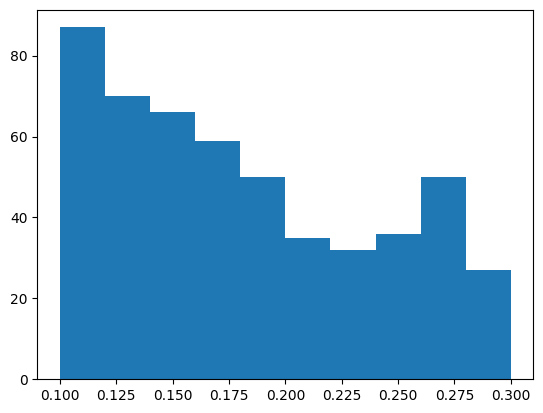

In [14]:
plt.hist(masses)

## Lomb Scargle Testing ##

## Getting entire 512 M-dwarf Sample ##

In [ ]:
ras = []
decs = []
for i in range(len(ra)):
    # print(i)
    # print( str(ra[i]),str(dec[i]))
    location = str(ra[i])+" "+str(dec[i])
    c = SkyCoord(location,unit=(u.hourangle, u.deg))
    ras.append(c.ra.degree)
    decs.append(c.dec.degree)

In [ ]:
file_name_dict = {}

In [ ]:
# cycle through and grab first 10 m-dwarfs:
file_paths = []
for num in range(2):
    print(f"Star {num}:",names[num])
    observations = Observations.query_criteria(obs_collection='TESS', s_dec=[decs[num]-.1,decs[num]+.1],s_ra=[ras[num]-.1,ras[num]+.1])
    short_exposure_obs = observations[observations['t_exptime']==20.0]
    if len(short_exposure_obs) > 0:
        product_list = Observations.get_product_list(short_exposure_obs)
        product_list_lcs = product_list[product_list['productSubGroupDescription']=='FAST-LC']
        file_path_list = [str(i) for i in product_list_lcs['productFilename']]
        file_name_dict[f'{names[num]}'] = file_path_list
        file_paths.append(file_path_list)
        manifest = Observations.download_products(product_list_lcs)
    else: 
        print(f"No 20s Data on target{names[num]}")

In [ ]:
import csv

w = csv.writer(open("mdwarf_names2.csv", "w"))
# loop over dictionary keys and values
for key, val in file_name_dict.items():
    # write every key and value to file
    w.writerow([key, val])

In [ ]:
file_paths = get_fits_file_paths()
print(file_paths)

In [ ]:
def get_pickle_file_paths(num):
    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)
    file_paths = [str(i) for i in list(current_dir.glob(f"power_pickles/power_{num}_*.pkl"))]
    return file_paths

In [ ]:
for i in range(2,514):
    m_dwarf_sample.at[i, 'power arrays'] = get_pickle_file_paths(i-2)

In [ ]:
all_frequencies = []
all_powers = np.array([])
for row in tqdm(range(0,10)):
    source_name = names[row]
    pickle_files = []
    for num in range(len(eval(np.array(m_dwarf_sample["file paths"])[row]))):
        try:
            i = eval(np.array(m_dwarf_sample["file paths"])[row])[num]
            path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
            time, flux = plot_TESS(path,True,source_name)
            clean_time, clean_flux = clean_data(time, flux,source_name,True)
            frequency, power = get_LG(clean_time, clean_flux,False)
            normalized_power = np.array(power/np.max(power))

            
            # with open(f'/Users/caleb/research/Astro_98/power_pickles/power_{row}_{num}.pkl','wb') as f:
            #     pickle.dump(normalized_power, f)


            print("High Power at a period of: "+ f"{(1/frequency[list(power).index(max(power))])}"+" d")


            if len(all_powers) == 0:
                all_powers = normalized_power
            else:
                all_powers += normalized_power

            if len(all_frequencies) == 0:
                all_frequencies = frequency

            pickle_files.append(f'/Users/caleb/research/Astro_98/power_pickles/power_{row}_{num}.pkl')
            
        except Exception:
            print('path error',path)
            print(traceback.format_exc())    
    print(pickle_files)
    m_dwarf_sample.at[row+2, 'power arrays'] = pickle_files

        

In [ ]:
m_dwarf_sample.to_csv("m_dwarf_sample_with_powers.csv")

In [ ]:
plt.plot(all_frequencies,all_powers/np.max(all_powers))
plt.xscale('log')
plt.title('All Powers Summed')
plt.xlabel('Frequency')
plt.ylabel("Power")

In [ ]:
names

In [ ]:
# get all powers
frequency = np.arange(0.01, 4000,.001)
all_powers_total = [0]*len(frequency)
for num in tqdm(range(2,514)):
    power_files = m_dwarf_sample["power arrays"][num]
    for i in range(len(power_files)):
            with open(power_files[i],'rb') as f:
                power = pickle.load(f)
                all_powers_total += np.array(power)



In [ ]:
plt.plot(frequency,all_powers_total)
plt.xscale('log')
# plt.yscale('log')
plt.title("Powers summed",fontsize=40)
plt.rcParams["figure.figsize"] = (30,10)
plt.ylabel("Power",fontsize=40)
plt.xlabel("Frequency [cycles/day]",fontsize=40)
plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=30)
plt.grid()
plt.show()

In [ ]:
# close ups
vals = [0,1000,10000,100000,1000000]
for i in range(len(vals)-1):
    plt.plot(frequency[vals[i]:vals[i+1]],all_powers_total[vals[i]:vals[i+1]])
    plt.xscale('log')
    # plt.yscale('log')
    plt.title("Powers summed",fontsize=40)
    plt.rcParams["figure.figsize"] = (30,10)
    plt.ylabel("Power",fontsize=40)
    plt.xlabel("Frequency [cycles/day]",fontsize=40)
    plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=30)
    plt.grid()
    plt.show()




In [ ]:
# highlighting interesting region
vals = [15000,19000]
for i in range(len(vals)-1):
    plt.plot(frequency[vals[i]:vals[i+1]],all_powers_total[vals[i]:vals[i+1]])
    plt.xscale('log')
    # plt.yscale('log')
    plt.title("Powers summed",fontsize=40)
    plt.rcParams["figure.figsize"] = (30,10)
    plt.ylabel("Power",fontsize=40)
    plt.xlabel("Frequency [cycles/day]",fontsize=40)
    plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=30)
    plt.axvspan(16.7,16.87,alpha=.2,color='grey')
    plt.grid()
    plt.show()


In [ ]:
m_dwarf_sample

In [ ]:
frequency = np.arange(0.01, 4000,.001)
all_frequencies = []
all_powers = np.array([])
for row in tqdm(range(100,115)):
    source_name = names[row]
    print('source',source_name)
    power_files = np.array(m_dwarf_sample["power arrays"])[row]    
    for num in range(len(eval(np.array(m_dwarf_sample["file paths"])[row]))):
        try:
            plt.rcParams["figure.figsize"] = (20,10)
            i = eval(np.array(m_dwarf_sample["file paths"])[row])[num]
            path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
            time, flux = plot_TESS(path,True,source_name)
            clean_time, clean_flux = clean_data(time, flux,source_name,True)

            with open(power_files[num],'rb') as f:
                power = pickle.load(f)
            plt.plot(frequency,power)
            plt.xscale('log')
            # plt.yscale('log')
            plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=30)
            plt.grid()

            plt.ylabel("Power",fontsize=40)
            plt.xlabel("Frequency [cycles/day]",fontsize=40)
            plt.show()

            print("High Power at a period of: "+ f"{(1/frequency[list(power).index(max(power))])}"+" d")


            if len(all_powers) == 0:
                all_powers = normalized_power
            else:
                all_powers += normalized_power

            if len(all_frequencies) == 0:
                all_frequencies = frequency

            
        except Exception:
            print('path error',path)
            print(traceback.format_exc())    

        

## Signal Injection Testing

In [5]:
# load the time stamps of a TESS observation

row = 10
lcf = lk.search_lightcurve(names[row], mission='TESS',exptime=20).download()
lc = lcf.PDCSAP_FLUX.normalize().remove_nans()
x = lc.time.value
y =lc.flux.value
yerr = lc.flux_err

/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_4274/1997524557.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.normalize().remove_nans()


In [ ]:
# basic sin wave
# first see what noise level is needed to pick up a signal
import numpy as np


amplitudes = np.arange(.01,.05,.01)
fig, axs = plt.subplots(len(amplitudes),2,figsize=(20,5*len(amplitudes)))

for fig_num,amplitude_factor in enumerate([0]):
        # fig, axs = plt.subplots(1,2,figsize=(20,5))

        rand = np.random.default_rng(42)


        t= np.array(x)-np.min(x)

        noise = 1 * np.random.normal(size=len(t))

        # period in days
        signal_period = 2

        signal_frequency = 1/signal_period
        signal_amplitude = 
        signal = signal_amplitude*np.sin((2/signal_period) * np.pi * t) 
        y = signal
        y = np.array(y)

        acoustic = False
        oscillation = False
        if acoustic:
                for i in range(1,20):
                        phase = 2*180*i
                        timestep = phase*t[1]
                        new_t = np.array([np.round((i-timestep),5) for i in t])
                        new_signal = signal_amplitude*np.sin((2/signal_period) * np.pi * new_t) 
                        axs[fig_num][0].plot(t,new_signal,color='green',linewidth=1)
                        y += np.array(new_signal)

        y =  y + noise

        if oscillation:
                oscillation_period = .02
                oscillation_factor = oscillation_factor
                oscillation_signal = oscillation_factor*signal_amplitude*np.sin((2/oscillation_period) * np.pi * t) 
                axs[fig_num][1].axvspan(oscillation_period-.001,oscillation_period+.001,label='Oscillation Period',ls='--',color='teal',alpha=.2)

                y += oscillation_signal

        # signal strength 
        signal_power = np.square(signal).mean()
        # noise strength
        noise_power = np.square(noise).mean()

        # SNR
        snr = 10 * np.log10(signal_power / noise_power)
        # from 12 min to 10 days in 20s intervals
        frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
        power = LombScargle(t, y).power(frequency)
        period = np.array([1/i for i in frequency])


        peaks, properties = find_peaks(power, prominence=.1)



        axs[fig_num][0].plot(t,y-noise,color='orange',linewidth=1)
        axs[fig_num][0].scatter(t,y,s=.1,color='black')
        axs[fig_num][0].set_xlabel("Time [d]",fontsize=20)
        axs[fig_num][0].set_ylabel("Amplitude",fontsize=20)
        axs[fig_num][0].set_ylim(1.2*np.min(y),1.6*np.max(y))

        axs[fig_num][1].plot(period,power,color='black')
        axs[fig_num][1].plot(period[peaks], power[peaks], "x",color='orange')

        axs[fig_num][1].set_xlabel("Period [d]",fontsize=20)
        axs[fig_num][1].set_ylabel("Power",fontsize=20)
        axs[fig_num][1].set_xscale('log')
        # axs[1].set_yscale('log')

        axs[fig_num][1].axvspan(signal_period-.2,signal_period+.2,color='teal',alpha=.2,label='Rotation Period')

        axs[fig_num][1].grid()

        axs[fig_num][1].legend(fontsize=20)

        textstr = '\n'.join((
        'Period=%.1f d' % (signal_period, ),
        'Amplitude=%.4f' % (signal_amplitude, ),
        'SNR=%.2f' % (snr, ),
        ))        
        if oscillation:
                textstr = '\n'.join((
                'Period=%.1f d' % (signal_period, ),
                r'$A_{rotation}$=%.2f' % (signal_amplitude, ),
                r'$A_{oscillation}/A_{rotation}$=%.2f' % (oscillation_factor, ),
                r'$SNR_{rotation}$=%.2f' % (snr, ),
                ))        


        props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
        axs[fig_num][0].text(0,1.5*np.max(y),textstr, fontsize=15,
                horizontalalignment='left',verticalalignment='top', bbox=props)
        axs[fig_num][0].tick_params(labelsize=15)
        axs[fig_num][1].tick_params(labelsize=15)


plt.legend(fontsize=20)
plt.show()

In [ ]:
# acoustic
# first see what noise level is needed to pick up a signal of oscillations on top of rotation
import numpy as np


amplitudes = [np.arange(.01,.1,.02)]
fig, axs = plt.subplots(len(amplitudes),2,figsize=(20,5*len(amplitudes)))

for fig_num,amplitude_factor in tqdm(enumerate(amplitudes)):
        # fig, axs = plt.subplots(1,2,figsize=(20,5))

        rand = np.random.default_rng(42)


        t= np.array(x)-np.min(x)

        noise = 1 * np.random.normal(size=len(t))

        # period in days
        signal_period = .2

        signal_frequency = 1/signal_period
        signal_amplitude = amplitude_factor
        signal = signal_amplitude*np.sin((2/signal_period) * np.pi * t) 
        y = signal
        y = np.array(y)

        acoustic = False
        oscillation = False
        if acoustic:
                for i in range(1,5):
                        phase = 2*180*i
                        timestep = phase*t[1]
                        new_t = np.array([np.round((i-timestep),5) for i in t])
                        new_signal = signal_amplitude*np.sin(((2)/(signal_period+i/100)) * np.pi * new_t) 
                        axs[fig_num][0].plot(t,new_signal,color='green',linewidth=1)
                        y += np.array(new_signal)

        y =  y + noise

        if oscillation:
                oscillation_period = .02
                oscillation_factor = oscillation_factor
                oscillation_signal = oscillation_factor*signal_amplitude*np.sin((2/oscillation_period) * np.pi * t) 
                axs[fig_num][1].axvspan(oscillation_period-.001,oscillation_period+.001,label='Oscillation Period',ls='--',color='teal',alpha=.2)

                y += oscillation_signal

        # signal strength 
        signal_power = np.square(signal).mean()
        # noise strength
        noise_power = np.square(noise).mean()

        # SNR
        snr = 10 * np.log10(signal_power / noise_power)
        # from 12 min to 10 days in 20s intervals
        frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
        power = LombScargle(t, y).power(frequency)
        period = np.array([1/i for i in frequency])


        peaks, properties = find_peaks(power, prominence=.1)



        axs[fig_num][0].plot(t,y-noise,color='orange',linewidth=1)
        axs[fig_num][0].scatter(t,y,s=.1,color='black')
        axs[fig_num][0].set_xlabel("Time [d]",fontsize=20)
        axs[fig_num][0].set_ylabel("Amplitude",fontsize=20)
        axs[fig_num][0].set_ylim(1.2*np.min(y),1.6*np.max(y))

        axs[fig_num][1].plot(period,power,color='black')
        axs[fig_num][1].plot(period[peaks], power[peaks], "x",color='orange')

        axs[fig_num][1].set_xlabel("Period [d]",fontsize=20)
        axs[fig_num][1].set_ylabel("Power",fontsize=20)
        axs[fig_num][1].set_xscale('log')
        # axs[1].set_yscale('log')

        axs[fig_num][1].axvline(x=signal_period,label='Rotation Period')

        axs[fig_num][1].grid()


        textstr = '\n'.join((
        'Period=%.1f d' % (signal_period, ),
        'Amplitude=%.4f' % (signal_amplitude, ),
        'SNR=%.2f' % (snr, ),
        ))        
        if oscillation:
                textstr = '\n'.join((
                'Period=%.1f d' % (signal_period, ),
                r'$A_{rotation}$=%.2f' % (signal_amplitude, ),
                r'$A_{oscillation}/A_{rotation}$=%.2f' % (oscillation_factor, ),
                r'$SNR_{rotation}$=%.2f' % (snr, ),
                ))        


        props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
        axs[fig_num][0].text(0,1.5*np.max(y),textstr, fontsize=15,
                horizontalalignment='left',verticalalignment='top', bbox=props)
        axs[fig_num][0].tick_params(labelsize=15)
        axs[fig_num][1].tick_params(labelsize=15)


plt.legend(fontsize=20)
plt.show()

In [ ]:
# first see what noise level is needed to pick up a signal of oscillations on top of rotation
import numpy as np


amplitudes = np.arange(.01,.5,.02)
fig, axs = plt.subplots(len(amplitudes),2,figsize=(20,5*len(amplitudes)))

for fig_num,oscillation_factor in enumerate(amplitudes):
        # fig, axs = plt.subplots(1,2,figsize=(20,5))

        rand = np.random.default_rng(42)


        t= np.array(x)-np.min(x)

        noise = 1 * np.random.normal(size=len(t))

        # period in days
        signal_period = 2

        signal_frequency = 1/signal_period
        signal_amplitude = 1
        signal = signal_amplitude*np.sin((2/signal_period) * np.pi * t) 
        y = signal
        y = np.array(y)

        acoustic = False
        oscillation = True
        if acoustic:
                for i in range(1,20):
                        phase = 2*180*i
                        timestep = phase*t[1]
                        new_t = np.array([np.round((i-timestep),5) for i in t])
                        new_signal = signal_amplitude*np.sin((2/signal_period) * np.pi * new_t) 
                        axs[fig_num][0].plot(t,new_signal,color='green',linewidth=1)
                        y += np.array(new_signal)

        y =  y + noise

        if oscillation:
                oscillation_period = .02
                oscillation_factor = oscillation_factor
                oscillation_signal = oscillation_factor*signal_amplitude*np.sin((2/oscillation_period) * np.pi * t) 
                axs[fig_num][1].axvspan(oscillation_period-.001,oscillation_period+.001,label='Oscillation Period',ls='--',color='teal',alpha=.2)

        y += oscillation_signal

        # signal strength 
        signal_power = np.square(signal).mean()
        # noise strength
        noise_power = np.square(noise).mean()

        # SNR
        snr = 10 * np.log10(signal_power / noise_power)
        # from 12 min to 10 days in 20s intervals
        frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
        power = LombScargle(t, y).power(frequency)
        period = np.array([1/i for i in frequency])


        peaks, properties = find_peaks(power, prominence=.1)



        axs[fig_num][0].plot(t,y-noise,color='orange',linewidth=1)
        axs[fig_num][0].scatter(t,y,s=.1,color='black')
        axs[fig_num][0].set_xlabel("Time [d]",fontsize=20)
        axs[fig_num][0].set_ylabel("Amplitude",fontsize=20)
        axs[fig_num][0].set_ylim(1.2*np.min(y),1.6*np.max(y))

        axs[fig_num][1].plot(period,power,color='black')
        axs[fig_num][1].plot(period[peaks], power[peaks], "x",color='orange')

        axs[fig_num][1].set_xlabel("Period [d]",fontsize=20)
        axs[fig_num][1].set_ylabel("Power",fontsize=20)
        axs[fig_num][1].set_xscale('log')
        # axs[1].set_yscale('log')

        axs[fig_num][1].axvline(x=signal_period,label='Rotation Period')

        axs[fig_num][1].grid()


        textstr = '\n'.join((
        'Period=%.1f d' % (signal_period, ),
        'Amplitude=%.4f' % (signal_amplitude, ),
        'SNR=%.2f' % (snr, ),
        ))        
        if oscillation:
                textstr = '\n'.join((
                'Period=%.1f d' % (signal_period, ),
                r'$A_{rotation}$=%.2f' % (signal_amplitude, ),
                r'$A_{oscillation}/A_{rotation}$=%.2f' % (oscillation_factor, ),
                r'$SNR_{rotation}$=%.2f' % (snr, ),
                ))        


        props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
        axs[fig_num][0].text(0,1.5*np.max(y),textstr, fontsize=15,
                horizontalalignment='left',verticalalignment='top', bbox=props)
        axs[fig_num][0].tick_params(labelsize=15)
        axs[fig_num][1].tick_params(labelsize=15)


plt.legend(fontsize=20)
plt.show()

In [ ]:
LS_frequency = np.arange(0.01, 4000,.001)
power = LombScargle(t, y).power(LS_frequency)

In [ ]:
plt.plot(LS_frequency, power)       
plt.xscale('log')
# plt.yscale('log')

# get SNR of peak
print('median',np.std(power))
print("Sigma > median",(np.max(power)-np.median(power))/np.std(power))

In [ ]:
m_dwarf_sample

In [ ]:
# then see what how small oscillations can be relative to sunspots

import numpy as np

rand = np.random.default_rng(42)

t = np.arange(0,26.8,.00023)

noise = 25 * error
signal = 1*np.sin(2/(2) * np.pi * t) 

y = signal+noise

osciilation_noise = .5 * error
osciilation_signal = .5*np.sin(2/((1/10)) * np.pi * t) 


oscillations = osciilation_signal+osciilation_noise

y = y + oscillations

clean_time, clean_flux = clean_data(t, y,'test',False)



plt.scatter(t,y,s=.1)
plt.plot(clean_time, clean_flux,color='black',linewidth=1)


In [ ]:
LS_frequency = np.arange(0.01, 4000,.001)
power = LombScargle(t, y).power(LS_frequency)

In [ ]:
plt.plot(LS_frequency, power)       
plt.xscale('log')
plt.axvspan(1/.1-1,1/.1+1,alpha=.2)
print('median',np.std(power))
print("Sigma > median",(np.max(power)-np.median(power))/np.std(power))

## Summed Powers

In [ ]:
with open('/Users/caleb/research/Astro_98/lomb_scargles/LS_8_0.pkl','rb') as f:
    power = pickle.load(f)
frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
plt.plot([1/i for i in frequency],power)
plt.xscale('log')

In [ ]:
# get all powers
frequency = np.arange(0.01, 4000,.001)
for num in tqdm(range(100,514)):
    power_files = m_dwarf_sample["power arrays"][num]
    for i in range(len(power_files)):
            with open(power_files[i],'rb') as f:
                power = pickle.load(f)
                plt.plot(frequency[15000:19000],power[15000:19000])
                plt.xscale('log')
                plt.axvspan(16.7,16.87,alpha=.2,color='grey')
                plt.rcParams["figure.figsize"] = (10,5)
                plt.title(names[num-2])
                plt.show()


In [ ]:
# examine specific source

period = [1/i for i in frequency]
for row in range(1,5):
    source_name = names[row]
    print(source_name)
    power_files = eval(np.array(m_dwarf_sample["power arrays"])[row])
    file_paths = np.array(m_dwarf_sample["file paths"])
    row_paths = eval(file_paths[row])
    print(len(row_paths))
    for num in range(len(row_paths)):
        try:
            i = row_paths[num]
            path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
            time, flux = plot_TESS(path,False,source_name)

            window_size= 180
            clean_time, clean_flux, median_flux,rotation_period, max_power = clean_data(time, flux,source_name,False,window_size)
            
            fig, axs = plt.subplots(1,3,figsize=(20,5))

            # frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
            frequency = np.arange(0.004, 4000,0.008)
            power = LombScargle(clean_time, clean_flux).power(frequency)
            period = [1/i for i in frequency]

            axs[0].scatter(time, flux,color='black',s=1)
            rotation_strength = 'strong'
            if max_power > .15:
                rotation_label= f"Rotation Period of {np.round(rotation_period,2)} d"
            if max_power < .15:
                rotation_label= "Weak Rotation Period"
                rotation_strength = 'weak'

            with open(f'/Users/caleb/research/Astro_98/improved_scargles/LS_star_{row}_observation_{num+1}_of_{len(row_paths)}.pkl','wb') as f:
                pickle.dump(power, f)

            props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
            # place a text box in upper left in axes coords
            axs[0].text(np.min(time),np.mean(flux)+.9*(np.max(flux)-np.mean(flux)),rotation_label, fontsize=15, horizontalalignment='left',verticalalignment='bottom', bbox=props)

            axs[0].plot(time[int(window_size/2):-int(window_size/2)], np.array(median_flux),color='orange',linewidth=1)
            axs[0].set_ylabel("Flux",fontsize=20)
            axs[0].set_xlabel("Time [d]",fontsize=20)


            axs[1].scatter(clean_time, clean_flux,color='black',s=1)
            axs[1].tick_params(labelsize=15)
            axs[1].grid()
            axs[1].set_ylabel("Flux Residuals",fontsize=20)
            axs[1].set_xlabel("Time [d]",fontsize=20)
            plt.suptitle(source_name,fontsize=20)


            axs[2].plot(period,power)
            axs[2].scatter(period[list(power).index(max(power))],power[list(power).index(max(power))],color='orange',s=150,marker='x',label=f'Max Power: {np.round(period[list(power).index(max(power))],3)} d')

            # axs[1].set_xscale('log')
            # axs[1].set_yscale('log')
            axs[2].tick_params(axis='both', which='both',direction='inout',length=15,labelsize=15)
            axs[2].grid()

            axs[2].set_ylabel("Power",fontsize=20)
            axs[2].set_xlabel("Period [d]",fontsize=20)
            axs[2].set_xscale("log")
            axs[2].ticklabel_format(axis='y', style='sci',scilimits=(.01,100))
            
            plt.subplots_adjust(wspace=.3)
            plt.legend(fontsize=15)
            plt.tight_layout()
            plt.savefig(f'/Users/caleb/research/Astro_98/Figures/star_{row}_{source_name}_observation_{num+1}_of_{len(row_paths)}_{rotation_strength}_rotation.png')
            plt.show()

            
        except Exception:
            print('path error',path)
            print(traceback.format_exc())    


GJ 1001
weird
GJ 1002
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


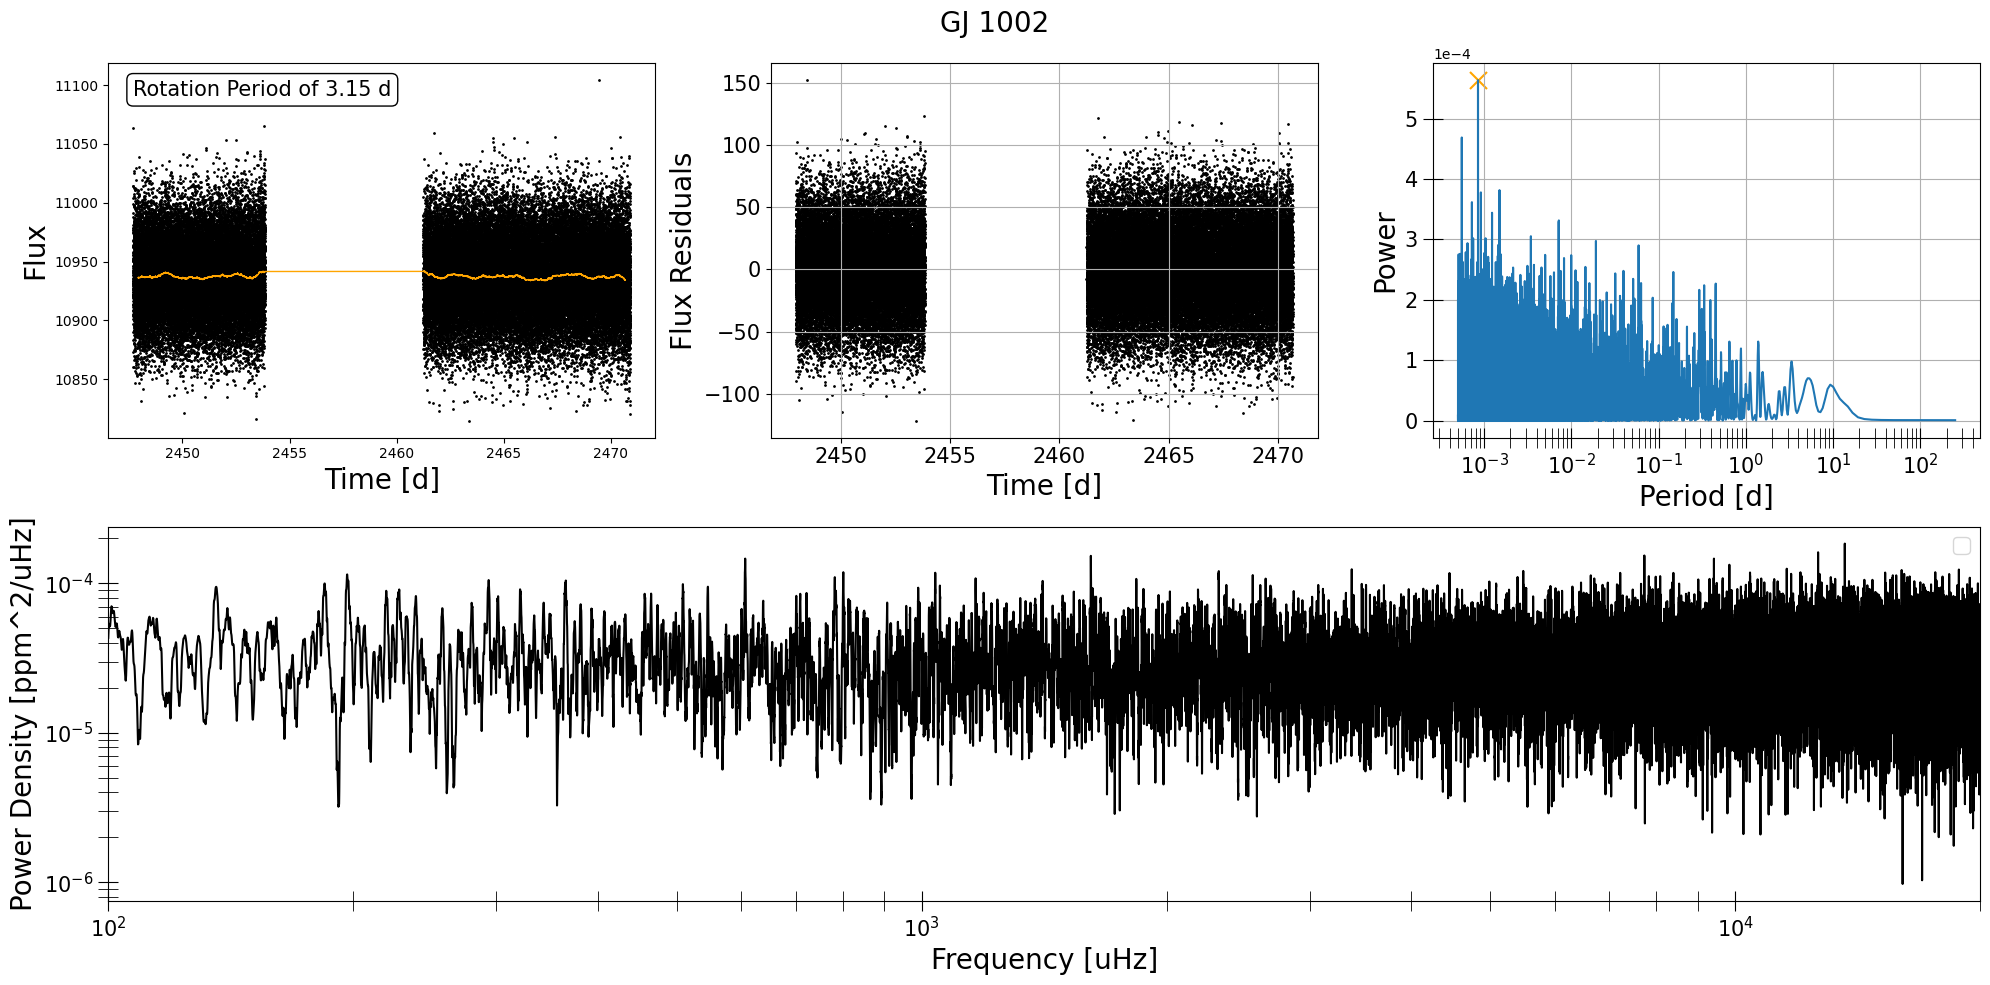

LP 191-43
0
LSPM 0011+5908
2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


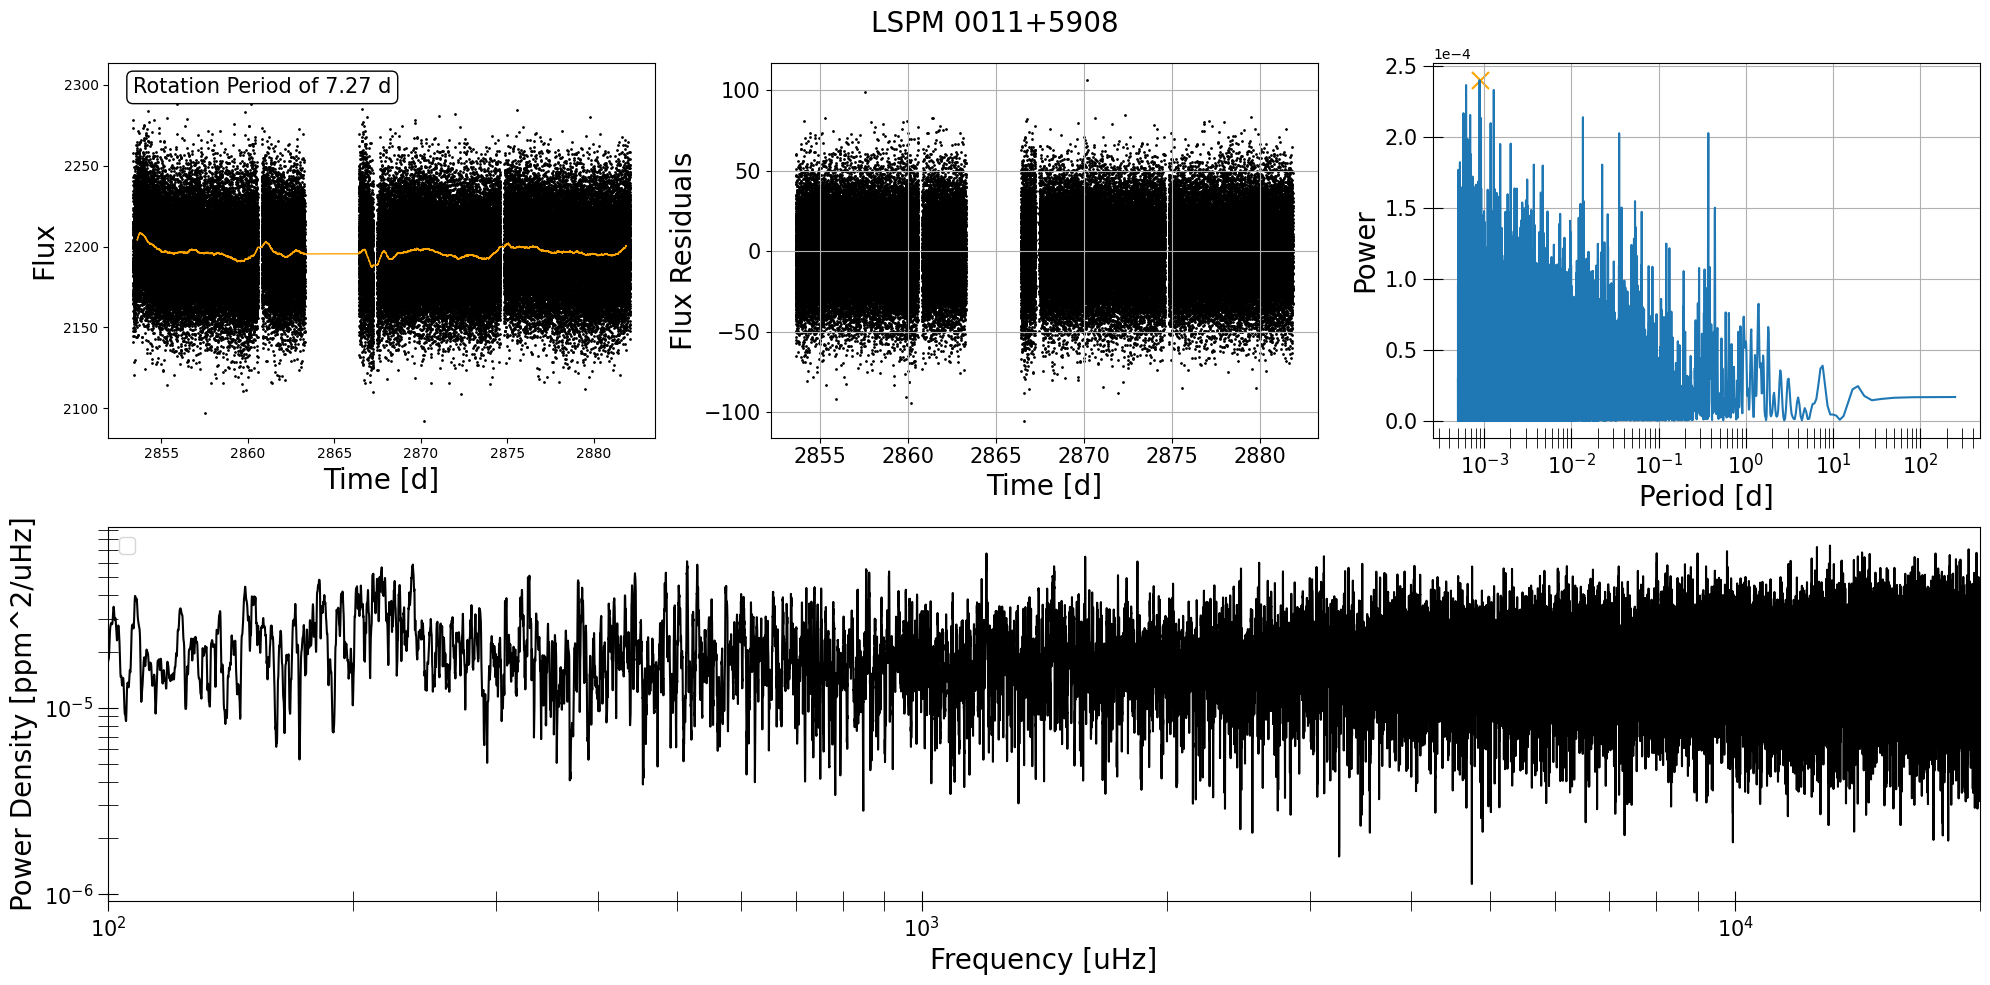

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


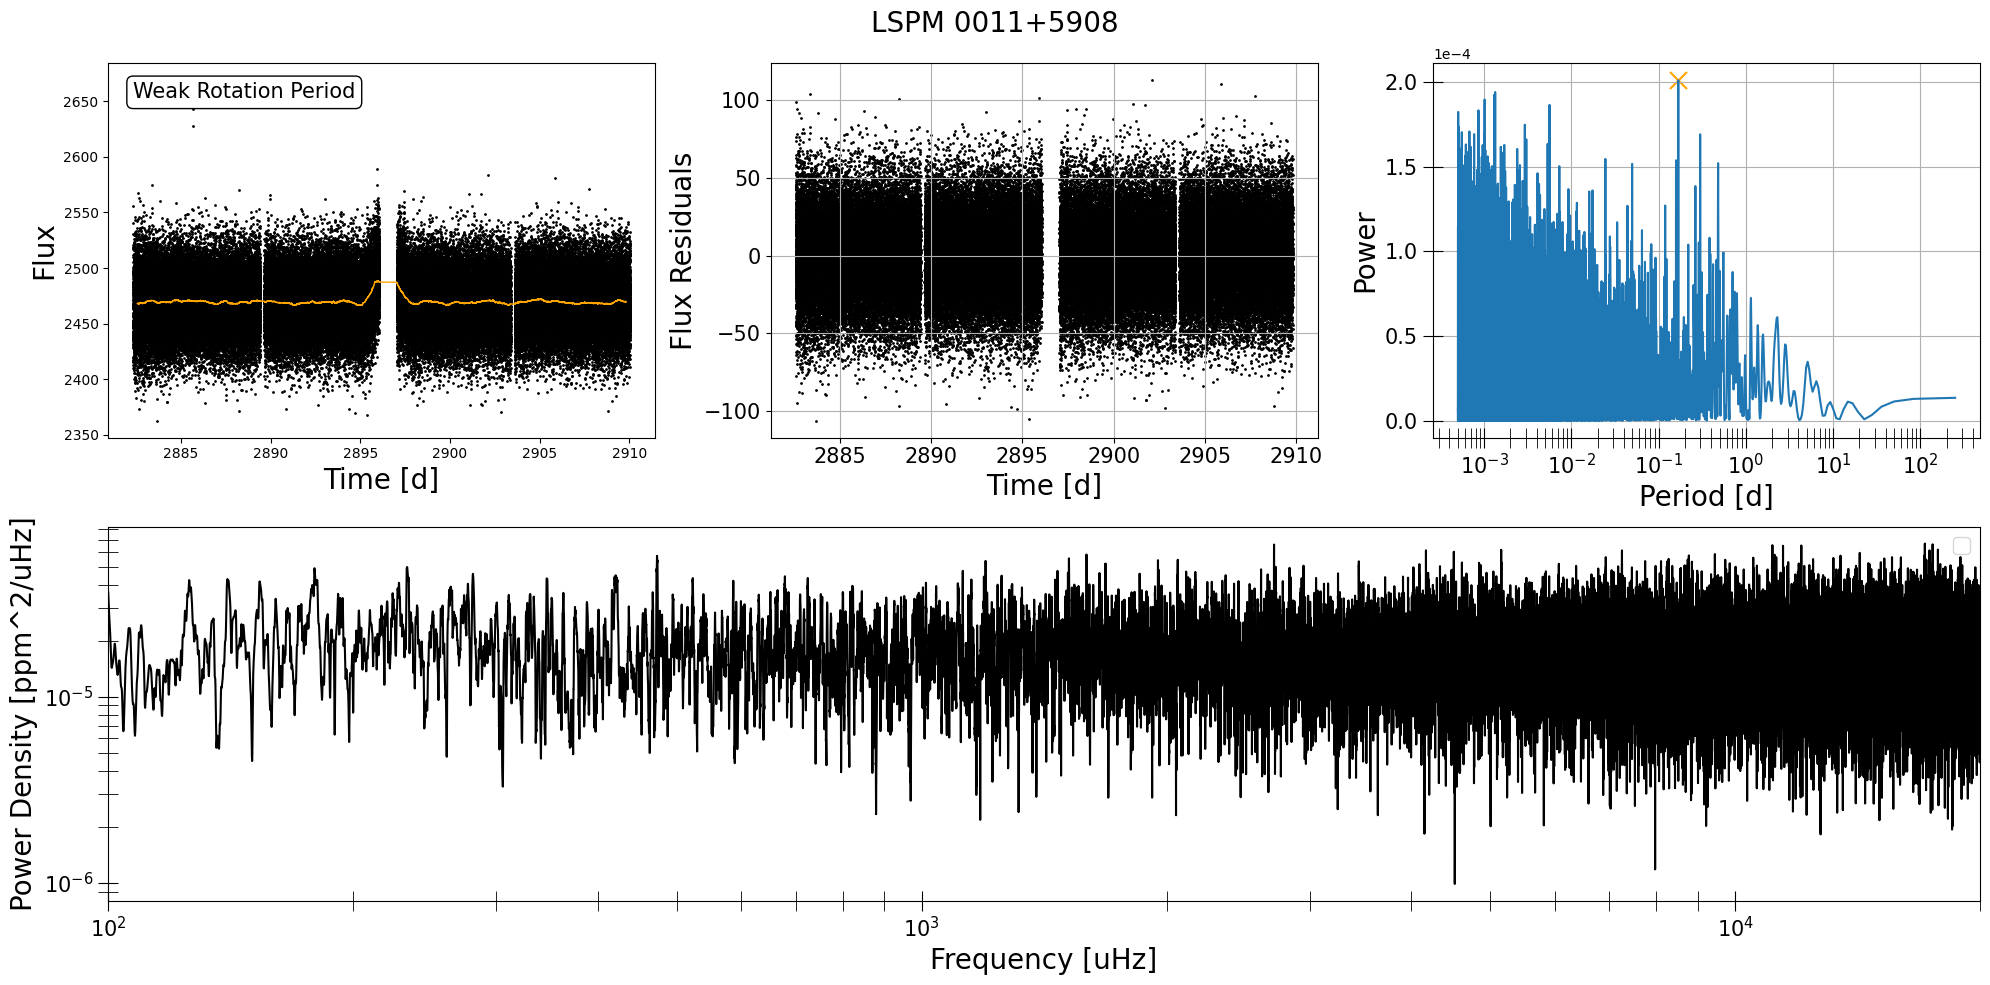

GJ 1005
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


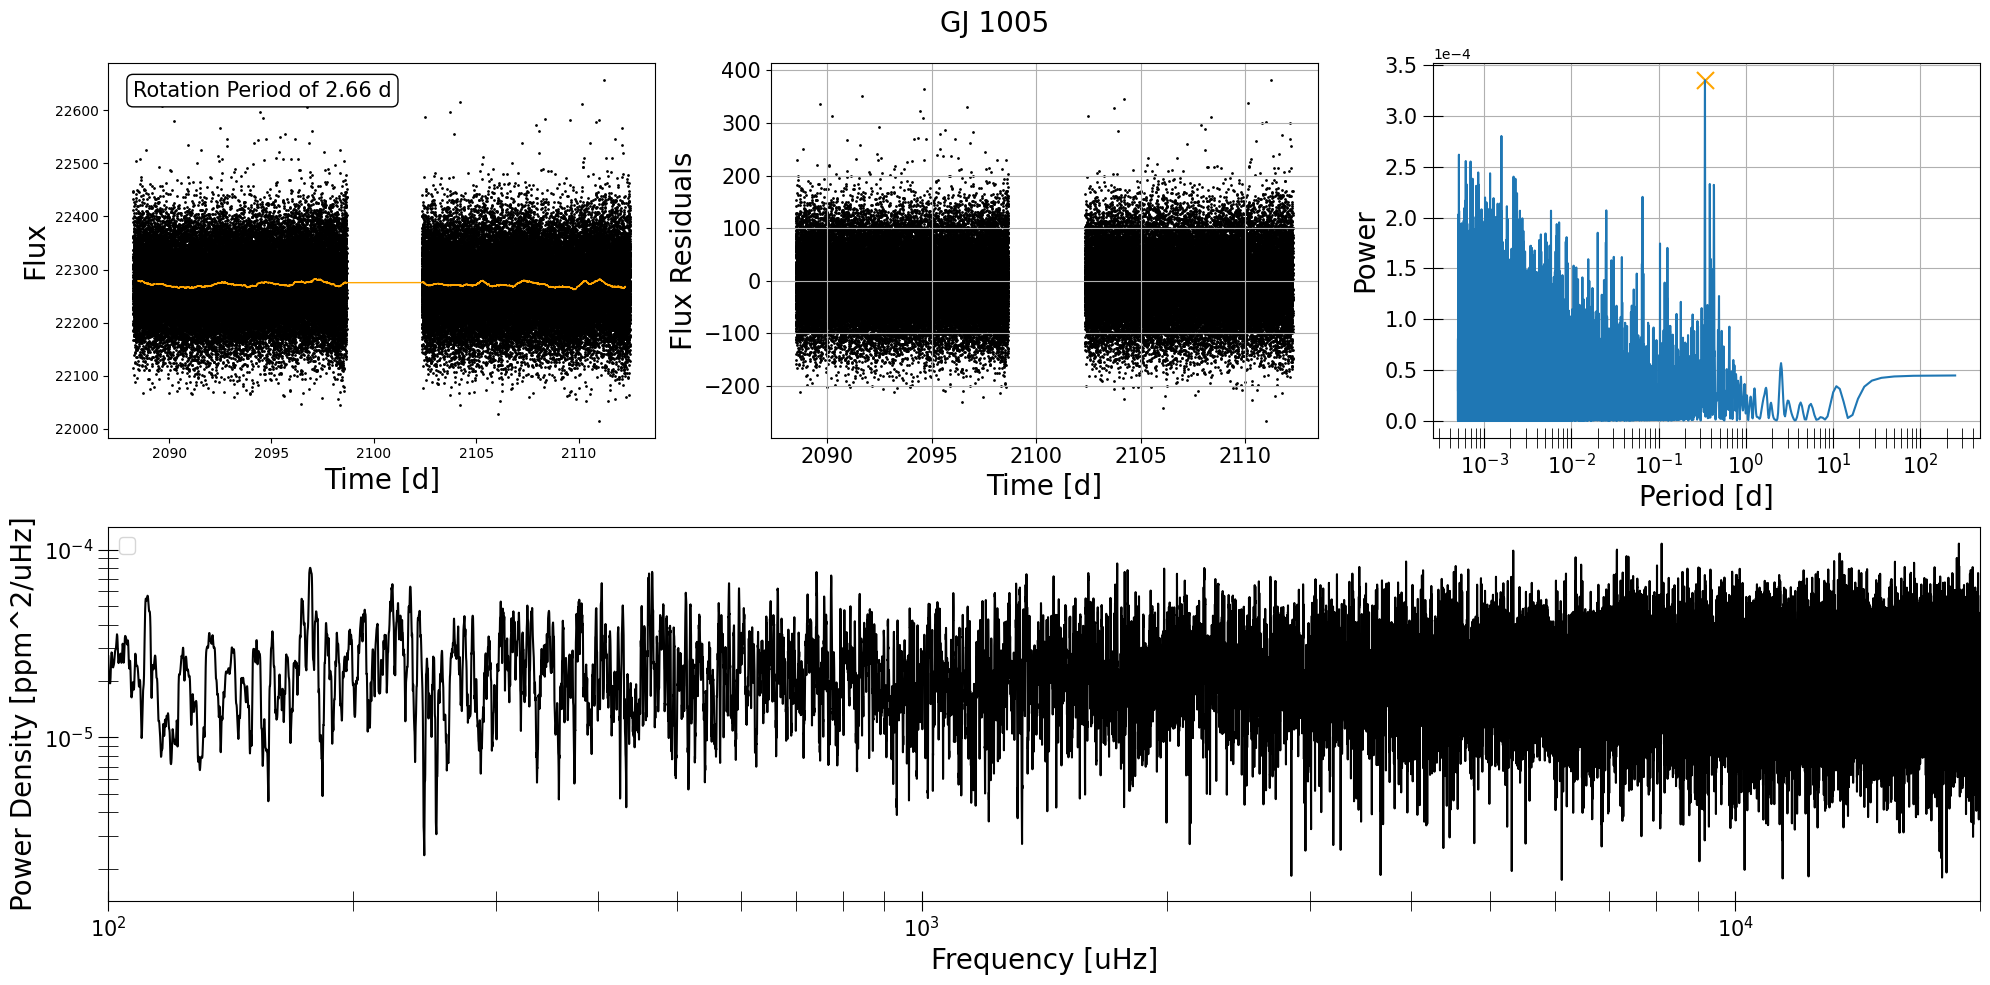

GJ 1005
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


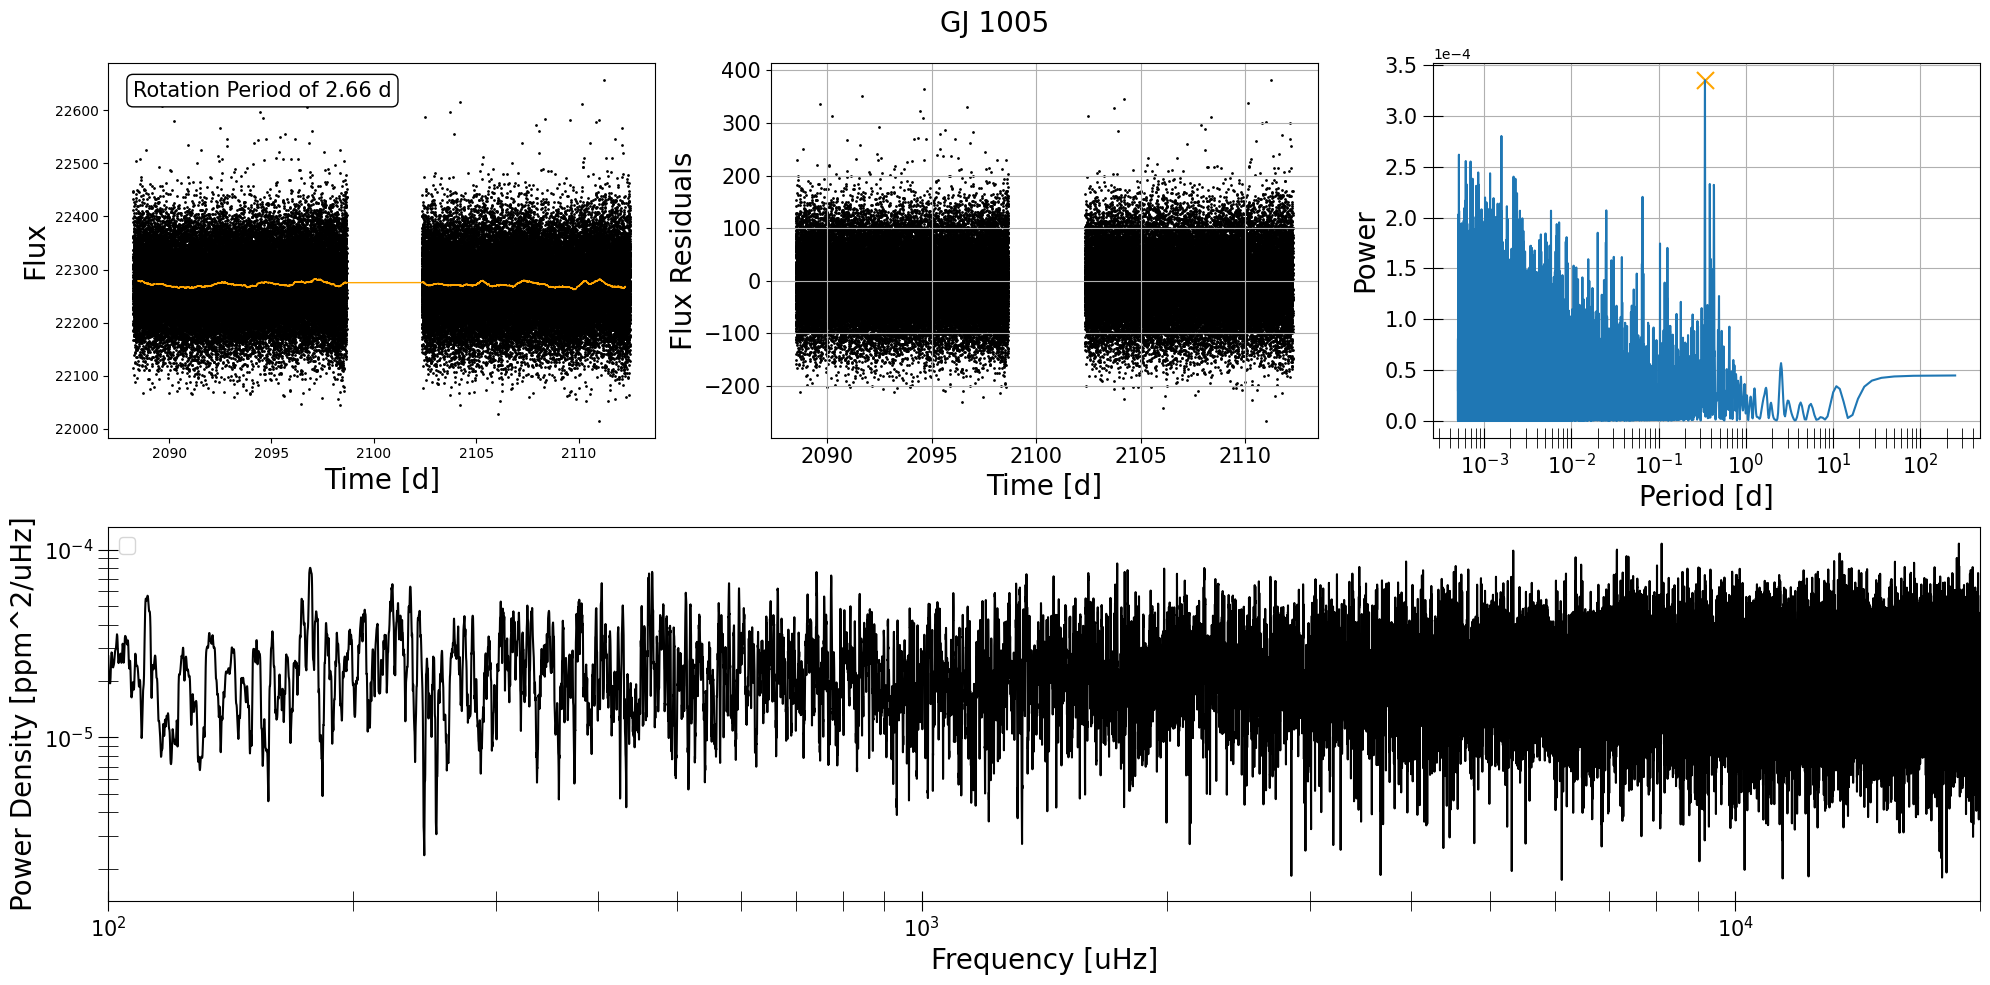

GJ 12
3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


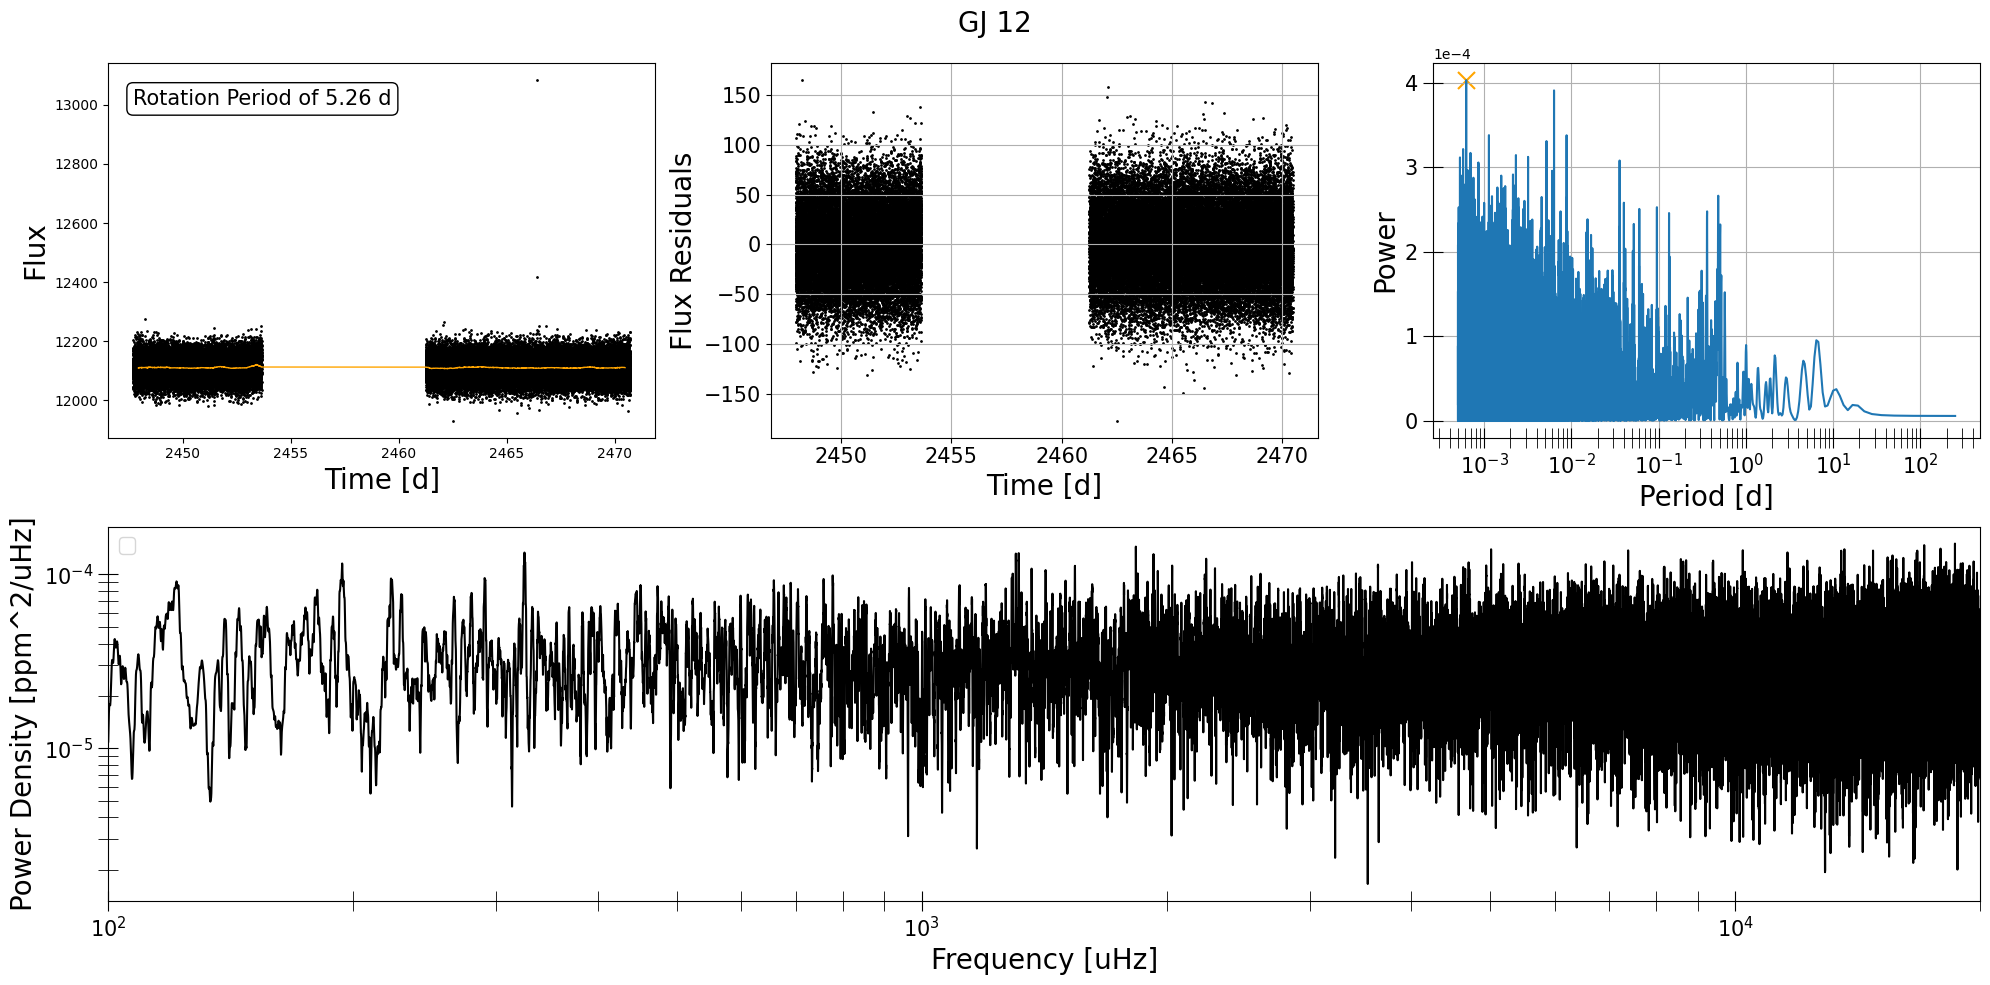

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


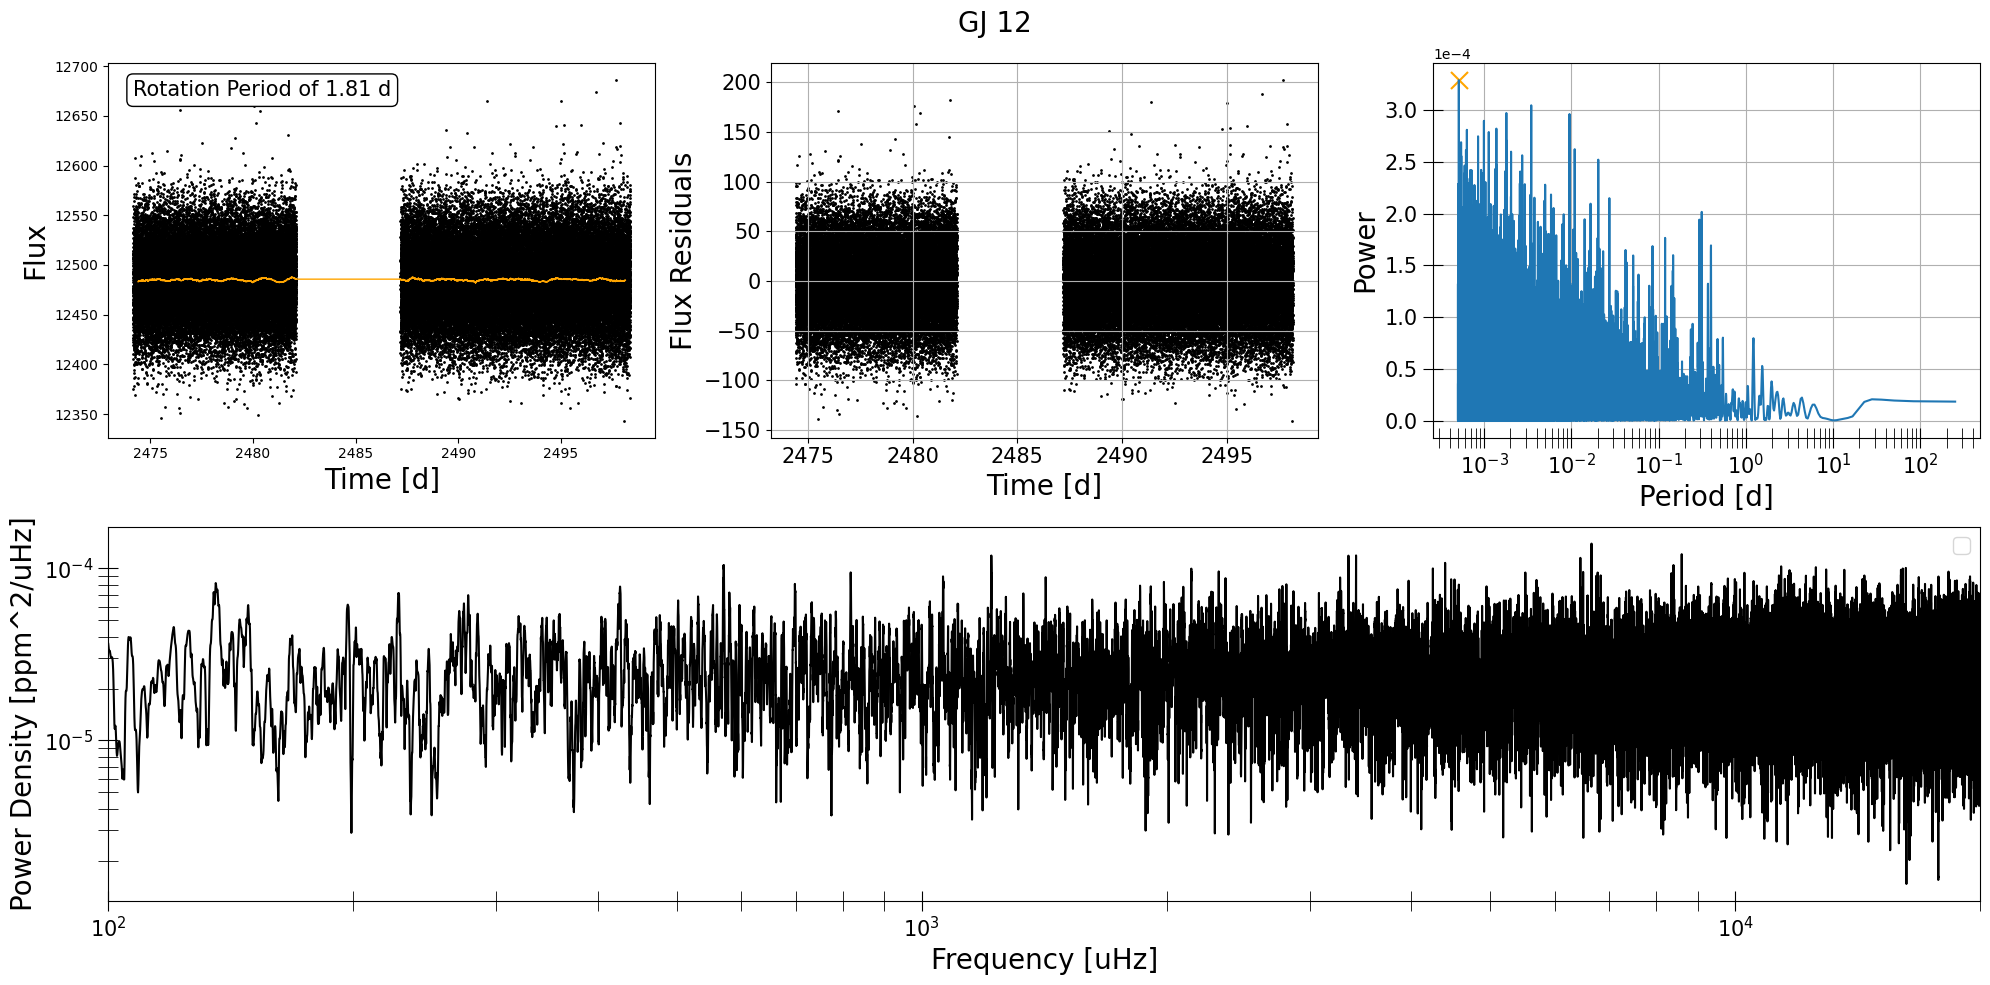

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


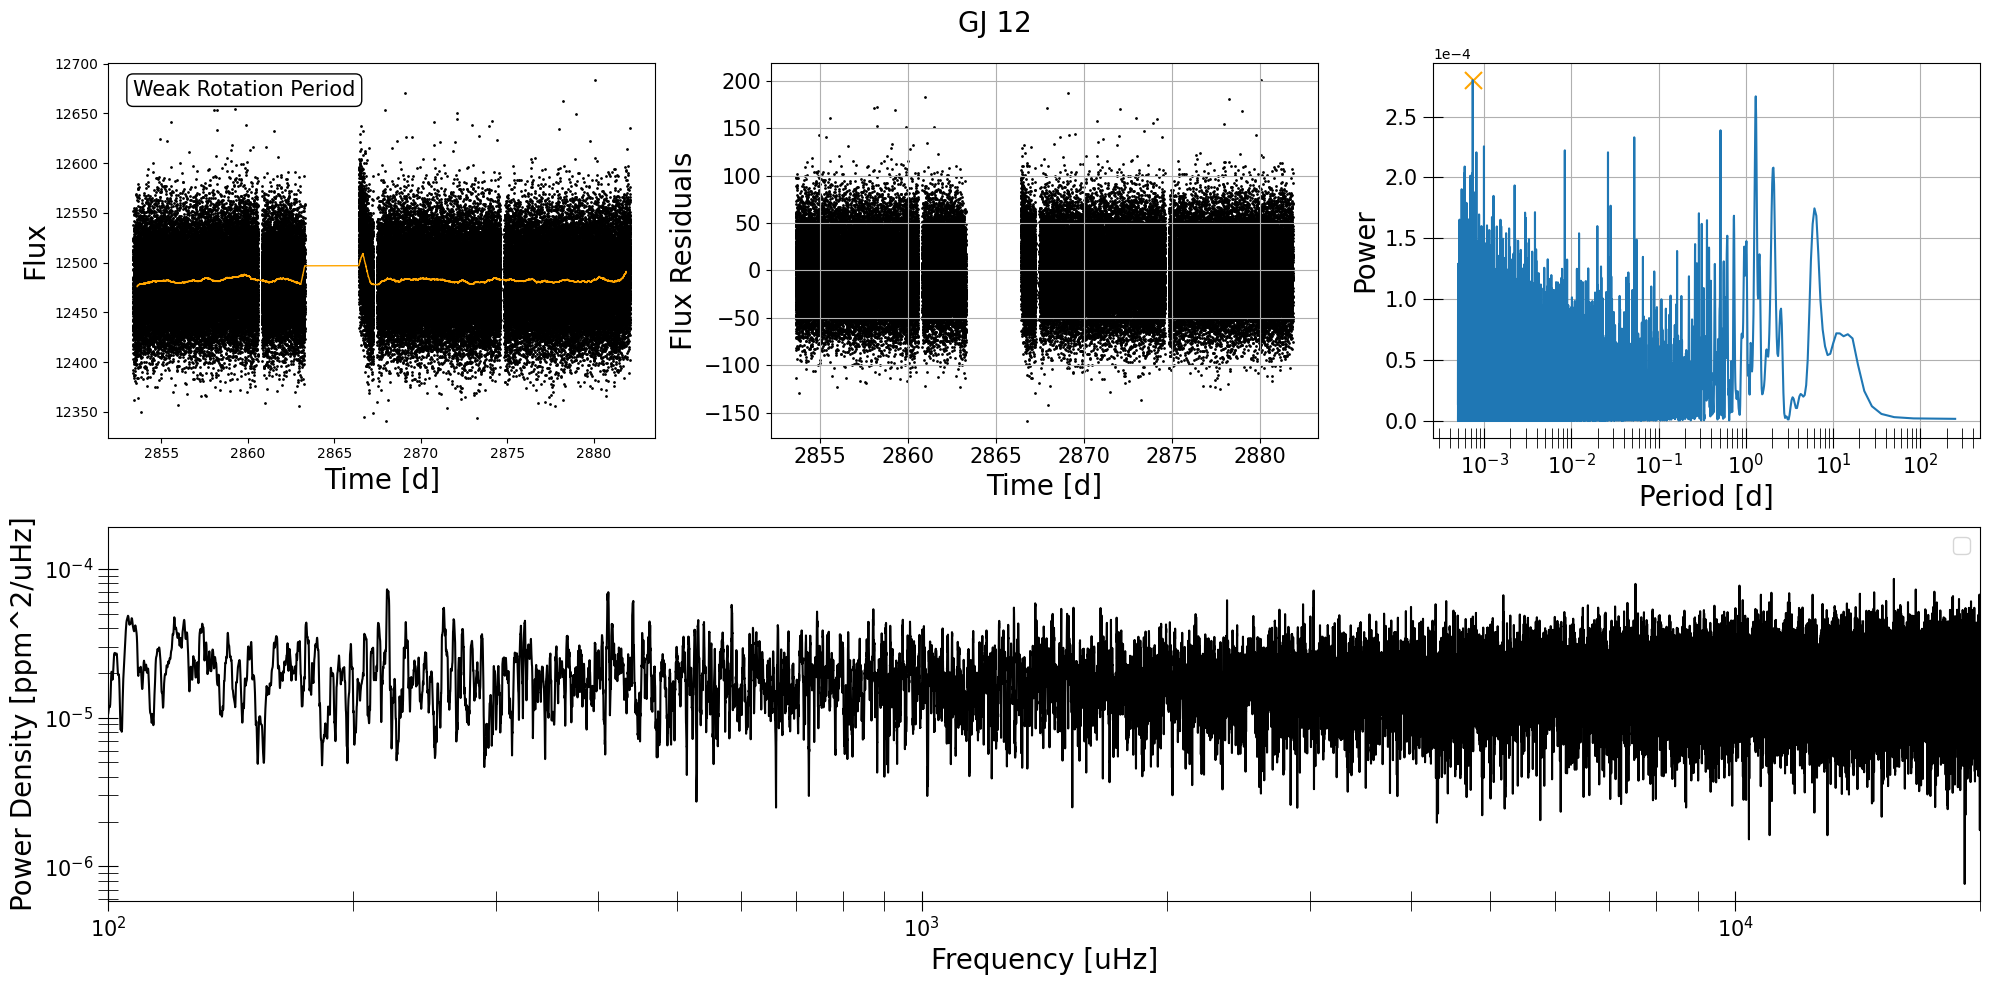

GJ 15
0
LHS 112
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


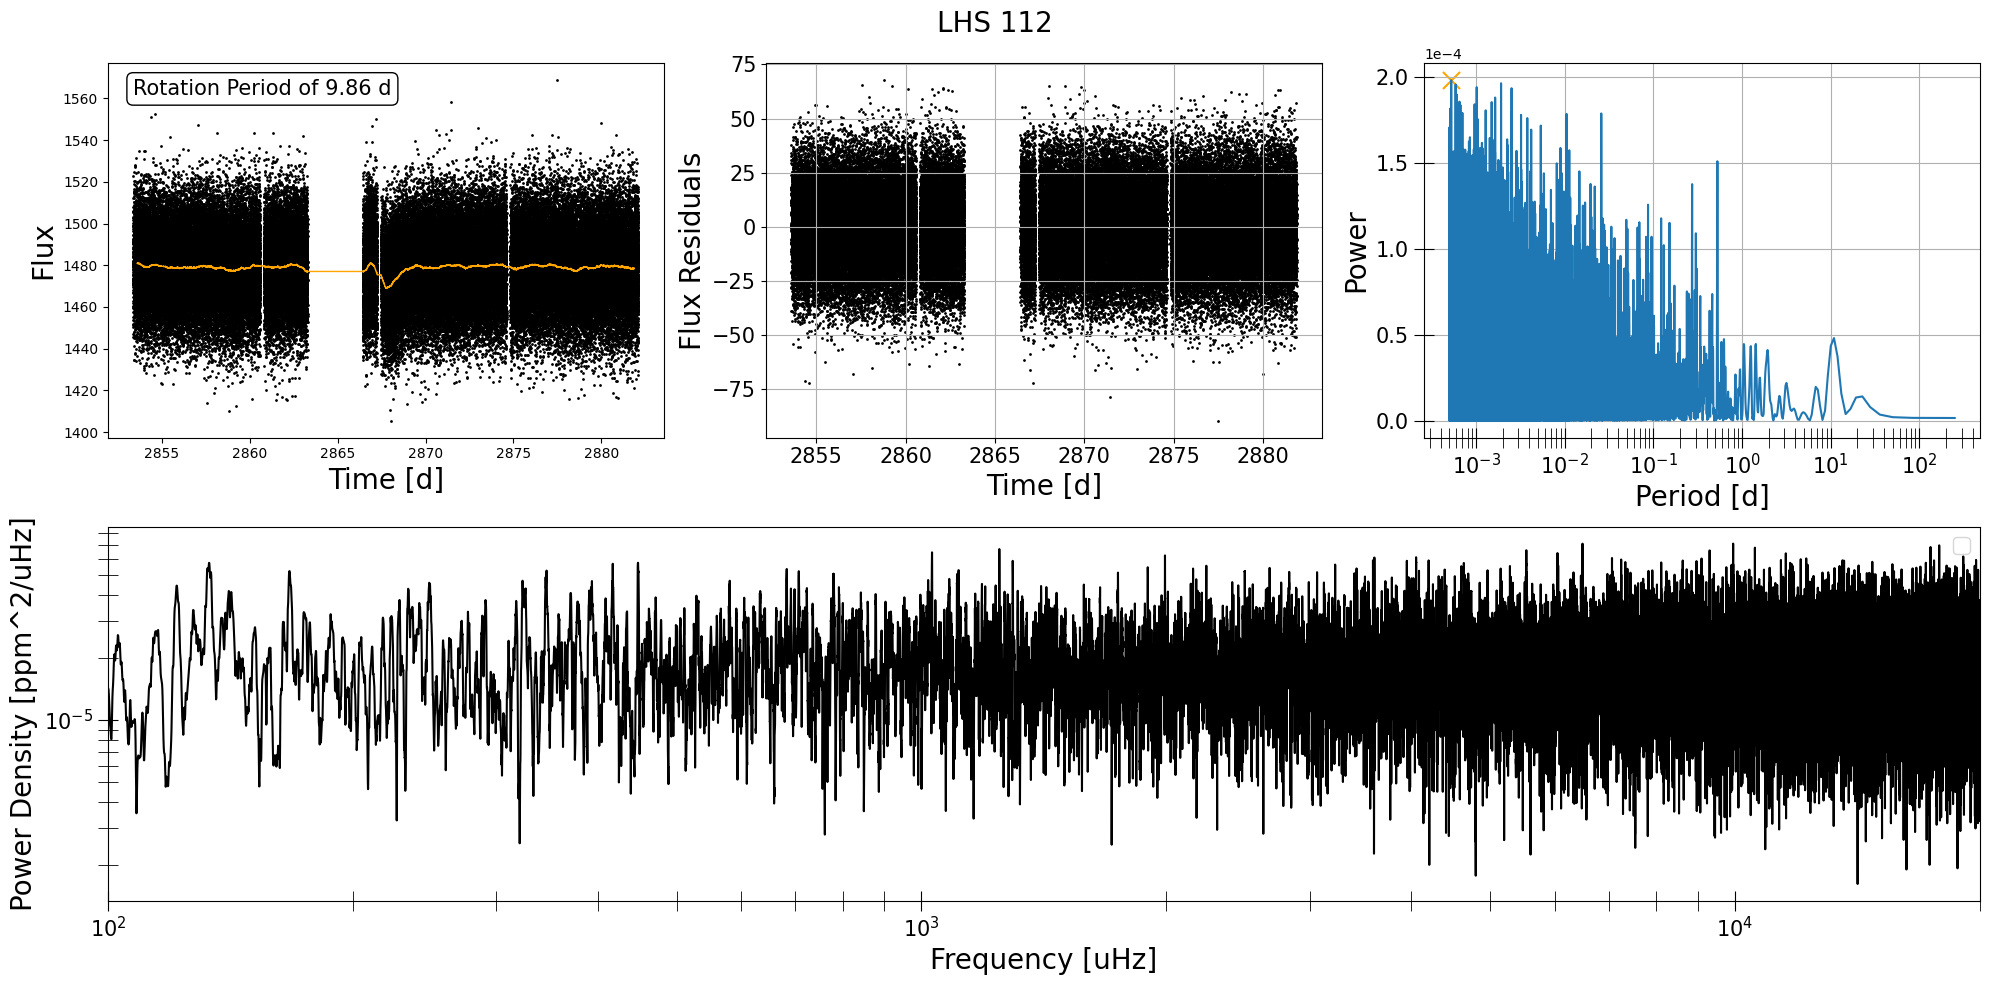

GJ 2005
1
path error /Users/caleb/research/Astro_98/mastDownload/TESS/tess2020238165205-s0029-0000000340703996-0193-a_fast/tess2020238165205-s0029-0000000340703996-0193-a_fast-lc.fits
Traceback (most recent call last):
  File "/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_25115/680907038.py", line 17, in <module>
    time, flux = plot_TESS(path,False,source_name)
  File "/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_25115/118225374.py", line 2, in plot_TESS
    with fits.open(fits_file_path, mode="readonly") as hdulist:
  File "/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/astropy/io/fits/hdu/hdulist.py", line 213, in fitsopen
    return HDUList.fromfile(
  File "/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/astropy/io/fits/hdu/hdulist.py", line 476, in fromfile
    return cls._readfrom(
  File "/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/astropy/io/fits/hdu/hdulist.py", line 1224, in _readfro

In [11]:
# redo analysis on all M-dwarfs

all_scargle_paths = []
for row in range(10):
    try:
        source_name = names[row]
        print(source_name)
        power_files = eval(np.array(m_dwarf_sample["power arrays"])[row])
        file_paths = np.array(m_dwarf_sample["file paths"])
        row_paths = eval(file_paths[row])
        print(len(row_paths))
        scargle_paths = []
        for num in range(len(row_paths)):
            try:
                i = row_paths[num]
                path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
                time, flux = plot_TESS(path,False,source_name)

                window_size= 2000
                clean_time, clean_flux, median_flux,rotation_period, max_power = clean_data(time, flux,source_name,False,window_size)
                
                # frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
                frequency = np.arange(0.004, 2000,0.008)
                power = LombScargle(clean_time, clean_flux).power(frequency)
                period = [1/i for i in frequency]

                rotation_strength = 'strong'
                if max_power > .15:
                    rotation_label= f"Rotation Period of {np.round(rotation_period,2)} d"
                if max_power < .15:
                    rotation_label= "Weak Rotation Period"
                    rotation_strength = 'weak'

                # with open(f'/Users/caleb/research/Astro_98/improved_scargles/LS_star_{row}_observation_{num+1}_of_{len(row_paths)}.pkl','wb') as f:
                #     pickle.dump(power, f)

                scargle_paths.append(f'/Users/caleb/research/Astro_98/improved_scargles/LS_star_{row}_observation_{num+1}_of_{len(row_paths)}.pkl')
                props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
                # place a text box in upper left in axes coords
                
                
                fig = plt.figure(figsize=(20,10))

                gs = fig.add_gridspec(2,3)
                ax1 = fig.add_subplot(gs[0, 0])
                ax2 = fig.add_subplot(gs[0, 1])
                ax3 = fig.add_subplot(gs[0, 2])
                ax4 = fig.add_subplot(gs[1, :])   

                axs = [ax1,ax2,ax3,ax4]

                axs[0].scatter(time, flux,color='black',s=1)
                axs[0].text(np.min(time),np.mean(flux)+.9*(np.max(flux)-np.mean(flux)),rotation_label, fontsize=15, horizontalalignment='left',verticalalignment='bottom', bbox=props)
                
                
                # get index of break in data
                # flag = 0
                # for t in range(len(time)):
                #     if (time[t+1]-time[t]) > .5:
                #         flag = t
                #         break
                
                # first_half_data = flux[:flag]
                # second_half_data = flux[flag:]
                # print('flag',time[flag])
                
                # savgol_flux = list(scipy.signal.savgol_filter(first_half_data, window_length=2001, polyorder=2))+list(scipy.signal.savgol_filter(second_half_data, window_length=2001, polyorder=2))

                # axs[0].plot(time, savgol_flux,color='pink',linewidth=1)

                axs[0].plot(time[int(window_size/2):-int(window_size/2)], np.array(median_flux),color='orange',linewidth=1)
                axs[0].set_ylabel("Flux",fontsize=20)
                axs[0].set_xlabel("Time [d]",fontsize=20)


                axs[1].scatter(clean_time, clean_flux,color='black',s=1)
                axs[1].tick_params(labelsize=15)
                axs[1].grid()
                axs[1].set_ylabel("Flux Residuals",fontsize=20)
                axs[1].set_xlabel("Time [d]",fontsize=20)
                plt.suptitle(source_name,fontsize=20)


                axs[2].plot(period,power)
                axs[2].scatter(period[list(power).index(max(power))],power[list(power).index(max(power))],color='orange',s=150,marker='x',label=f'Max Power: {np.round(period[list(power).index(max(power))],3)} d')

                # axs[1].set_xscale('log')
                # axs[1].set_yscale('log')
                axs[2].tick_params(axis='both', which='both',direction='inout',length=15,labelsize=15)
                axs[2].grid()

                axs[2].set_ylabel("Power",fontsize=20)
                axs[2].set_xlabel("Period [d]",fontsize=20)
                axs[2].set_xscale("log")
                axs[2].ticklabel_format(axis='y', style='sci',scilimits=(.01,100))
                

                freq_bin_smooth = 20
                frequency_microhertz = [(i*10**6)/(24*60*60) for i in frequency]
                smooth_frequency_microhertz, smooth_power = smooth_data(power,freq_bin_smooth,frequency_microhertz)

                with open(f'/Users/caleb/research/Astro_98/improved_scargles/LS_star_{row}_observation_{num+1}_of_{len(row_paths)}.pkl','wb') as f:
                    pickle.dump(smooth_power, f)

                # for i in range(len(smooth_power)):
                #     binned_power_per_freq.append((smooth_power[i]/(10**-6))**2/smooth_frequency_microhertz[i])

                axs[3].plot(smooth_frequency_microhertz, smooth_power,color='black')

                # plt.plot(frequency,power,alpha=.5)

                axs[3].set_xscale('log')
                axs[3].set_yscale('log')

                # plt.title("Lomb Scargle")
                axs[3].set_xlabel("Frequency [uHz]", fontsize=20)
                axs[3].set_ylabel("Power Density [ppm^2/uHz]" , fontsize=20)
                axs[3].tick_params(axis='both', which='both',direction='inout',length=15,labelsize=15)

                axs[3].set_xlim(10**2,2*10**4)
                # axs[3].set_ylim(.01,20)


                plt.subplots_adjust(wspace=.3)
                plt.legend(fontsize=15)
                plt.tight_layout()
                plt.savefig(f'/Users/caleb/research/Astro_98/improved_figures/star_{row}_{source_name}_observation_{num+1}_of_{len(row_paths)}_{rotation_strength}_rotation.png')
                plt.show()

                
            except Exception:
                print('path error',path)
                print(traceback.format_exc())    

        all_scargle_paths.append(scargle_paths)
    except:
        print('weird')
        all_scargle_paths.append([])

with open(f'/Users/caleb/research/Astro_98/all_scargle_paths.pkl','wb') as f:
    pickle.dump(all_scargle_paths, f)




In [ ]:
with open(f'/Users/caleb/research/Astro_98/all_scargle_paths.pkl','rb') as f:
    all_data = pickle.load(f)

In [13]:
all_scargle_paths

[[],
 ['/Users/caleb/research/Astro_98/improved_scargles/LS_star_1_observation_1_of_1.pkl'],
 [],
 ['/Users/caleb/research/Astro_98/improved_scargles/LS_star_3_observation_1_of_2.pkl',
  '/Users/caleb/research/Astro_98/improved_scargles/LS_star_3_observation_2_of_2.pkl'],
 ['/Users/caleb/research/Astro_98/improved_scargles/LS_star_4_observation_1_of_1.pkl'],
 ['/Users/caleb/research/Astro_98/improved_scargles/LS_star_5_observation_1_of_1.pkl'],
 ['/Users/caleb/research/Astro_98/improved_scargles/LS_star_6_observation_1_of_3.pkl',
  '/Users/caleb/research/Astro_98/improved_scargles/LS_star_6_observation_2_of_3.pkl',
  '/Users/caleb/research/Astro_98/improved_scargles/LS_star_6_observation_3_of_3.pkl'],
 [],
 ['/Users/caleb/research/Astro_98/improved_scargles/LS_star_8_observation_1_of_1.pkl'],
 [],
 []]

In [ ]:

summed = np.array([0.0]*(len(frequency)-20))
for data in all_data:
    for i in data:
        with open(i,'rb') as f:
            scargle = pickle.load(f)
            summed += np.array(scargle)

freq_bin_smooth = 20
smooth_frequency_microhertz, smooth_power = smooth_data(summed,freq_bin_smooth,frequency_microhertz)


In [ ]:
plt.plot(smooth_frequency_microhertz, smooth_power)
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,20000)

In [ ]:
plt.plot(smooth_frequency_microhertz, smooth_power)
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,20000)

In [ ]:
cwd = os.getcwd()
current_dir = pathlib.Path(cwd)

LS_paths = [str(i) for i in list(current_dir.glob(f"lomb_scargles/*.pkl"))]
figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/*.png"))]


In [ ]:
# add all powers
from IPython.display import Image, display

frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
period = [1/i for i in frequency]

index_1 = 0
index_2= -1

all_LS = np.array([0]*len(np.arange(.2,(24/.2),((20/(60*60))/24))[index_1:index_2]))
relative_strengths = []
weak_rotators = 0
for i,lomb_scargle in enumerate(LS_paths):
    with open(lomb_scargle,'rb') as f:
        power = pickle.load(f)
        short_period_powers = power[index_1:index_2]

        # long rotation period rotators
        max_power = np.max(power)
        strongest_period = period[np.argmin(power)]


        # only choose weak rotators
        star_number = int(str(f.name).split('_')[4])
        star_observation = int(str(f.name).split('_')[6])  
        figure_path = str(list(current_dir.glob(f"Figures/star_{star_number}_*_{star_observation}_of*.png"))[0])

        if 'weak' in figure_path and star_number != 356 and star_number != 357 :
            short_period_powers = short_period_powers/np.max(short_period_powers)
            all_LS = all_LS + short_period_powers
            weak_rotators +=1 
        # short period powers with high intensities
        if False:
            if np.max(short_period_powers) > .005 and np.max(short_period_powers) < .02:
                print(f)
                relative_strengths.append(np.max(short_period_powers))
                plt.plot(period[-480000:],short_period_powers)
                plt.show()
                # short_period_powers = short_period_powers/np.max(short_period_powers)
                print(f.name)
                print(star_number,star_observation)
                spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}*.png"))]

                file_paths = np.array(m_dwarf_sample["file paths"])
                row_paths = eval(file_paths[int(star_number)])
                print(row_paths)

        
                path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+row_paths[star_observation][:-8]+"/"+row_paths[star_observation]
                time, flux = plot_TESS(path,True,source_name)

                for i in spec_figures_paths:
                    if f"{star_observation}_of" in i:
                        display(Image(filename=i)) 


# all all powers in weak rotators


In [ ]:
# add all powers per specific mass
from IPython.display import Image, display

frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
period = [1/i for i in frequency]

index_1 = 0
index_2= -1


all_LS_per_mass = []
for i in range(4):
    all_LS = np.array([0]*len(np.arange(.2,(24/.2),((20/(60*60))/24))[index_1:index_2]))
    all_LS_per_mass.append(all_LS)

relative_strengths = []
weak_rotators = 0
for i,lomb_scargle in tqdm(enumerate(LS_paths)):
    with open(lomb_scargle,'rb') as f:
        power = pickle.load(f)
        short_period_powers = power[index_1:index_2]

        # long rotation period rotators
        max_power = np.max(power)
        strongest_period = period[np.argmin(power)]


        # only choose weak rotators
        star_number = int(str(f.name).split('_')[4])
        star_observation = int(str(f.name).split('_')[6])  
        figure_path = str(list(current_dir.glob(f"Figures/star_{star_number}_*_{star_observation}_of*.png"))[0])

        if 'weak' in figure_path and star_number != 356 and star_number != 357 :
            short_period_powers = short_period_powers/np.max(short_period_powers)

            # filter by mass

            mass_bin = int(np.floor((masses[star_number]-.1)/.05))
            print(star_number,masses[star_number],mass_bin)
            all_LS_per_mass[mass_bin] = all_LS_per_mass[mass_bin] + short_period_powers
            weak_rotators +=1 



        # short period powers with high intensities
        if False:
            if np.max(short_period_powers) > .005 and np.max(short_period_powers) < .02:
                print(f)
                relative_strengths.append(np.max(short_period_powers))
                plt.plot(period[-480000:],short_period_powers)
                plt.show()
                # short_period_powers = short_period_powers/np.max(short_period_powers)
                print(f.name)
                print(star_number,star_observation)
                spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}*.png"))]

                file_paths = np.array(m_dwarf_sample["file paths"])
                row_paths = eval(file_paths[int(star_number)])
                print(row_paths)

        
                path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+row_paths[star_observation][:-8]+"/"+row_paths[star_observation]
                time, flux = plot_TESS(path,True,source_name)

                for i in spec_figures_paths:
                    if f"{star_observation}_of" in i:
                        display(Image(filename=i)) 


# all all powers in weak rotators


In [ ]:
print(f"Sum of {weak_rotators} powers")

In [ ]:
str(list(current_dir.glob(f"Figures/star_{126}_*_{4}_of*.png"))[0])

In [ ]:
frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
period = [1/i for i in frequency]
frequency_microhertz = [(i*10**6)/(24*60*60) for i in frequency]

masses = [.1,.15,.2,.25,.3]

for i in range(4):
    plt.plot(frequency_microhertz[index_1:index_2],all_LS_per_mass[i])
    plt.xscale('log')
    plt.xlabel('Frequency [uHz]')
    plt.ylabel('Power')
    plt.title(f"M Dwarf Masses {masses[i]}-{masses[i+1]}")
    plt.show()


In [ ]:
frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
period = [1/i for i in frequency]
plt.plot(period[index_1:index_2],all_LS)
# plt.axvspan(.082,.0835,alpha=.3,color='grey')
plt.xlabel("Period",fontsize=30)
plt.ylabel("Power",fontsize=30)
plt.title("Summed",fontsize=30)
plt.tick_params(axis='both', which='both',direction='inout',length=15,labelsize=15)
# plt.axvspan(.082,.0835,alpha=.3,color='grey')
plt.xscale('log')
plt.grid()


In [ ]:
table_file_paths = np.array(m_dwarf_sample['file paths'])
multiple_observations = []
for i in range(len(table_file_paths)):
    path_list = eval(table_file_paths[i])
    if len(path_list) > 10:
        multiple_observations.append((i,len(path_list)))



In [ ]:
# plot only stars with multiple observations
for i in multiple_observations:
    num_obs = i[1]
    rows = int(np.ceil(num_obs / 4))
    fig, axs = plt.subplots(rows,4,figsize=(20,20))
    for obs in range(num_obs):
        try:
            with open(f'/Users/caleb/research/Astro_98/lomb_scargles/LS_star_{i[0]}_observation_{obs+1}_of_{num_obs}.pkl','rb') as f:
                power = pickle.load(f)
            name = names[i[0]]
            # long rotation period rotators
            max_power = np.max(power)
            strongest_period = period[np.argmax(power)]

            axs[int(np.floor(obs/4))][obs%4].plot(period,power/np.max(power))
            # axs[int(np.floor(obs/4))][obs%4].axvspan(.08,.1,alpha=.3,color='grey')
            axs[int(np.floor(obs/4))][obs%4].set_xlim(0.085,.095)
            axs[int(np.floor(obs/4))][obs%4].set_ylim(0,1.2)
        except:
            pass
    plt.suptitle(f"Star {i[0]}:{name}")
    plt.show()



In [ ]:
# plot specific star
star_number = 357
spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}*.png"))]
for i in spec_figures_paths:
    display(Image(filename=i)) 


In [ ]:
# wave packet?
# plot specific star
star_number = 219
spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}*.png"))]
for i in spec_figures_paths:
    display(Image(filename=i)) 


In [ ]:
# looking for .082 period rotators
frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
period = [1/i for i in frequency]

for i,lomb_scargle in enumerate(LS_paths):
    with open(lomb_scargle,'rb') as f:
        power = pickle.load(f)
    star_number = lomb_scargle.split('_')[4]
    name = names[int(star_number)]
    # long rotation period rotators
    max_power = np.max(power)
    strongest_period = period[np.argmax(power)]

    if strongest_period < .12:
        plt.title(f"Star {name}")
        plt.xlabel("Period")
        plt.ylabel("Power")
        plt.plot(period,power/np.max(power))
        plt.axvspan(.082,.0835,alpha=.3,color='grey')
        plt.xlim(0.05,.13)
        plt.ylim(0,1.2)
        plt.show()
        print(i)


## Multiple Observation Targets

In [15]:
table_file_paths = np.array(m_dwarf_sample['file paths'])
multiple_observations = []
for i in range(len(table_file_paths)):
    path_list = eval(table_file_paths[i])
    if len(path_list) > 2:
        multiple_observations.append((i,len(path_list)))

multiple_observations_stars = [i[0] for i in multiple_observations]

In [16]:
multiple_observations_star_names = [names[i] for i in multiple_observations_stars]

In [ ]:
for row in tqdm(multiple_observations_stars[30:31]):
    full_list_residuals = []
    full_list_times = []
    source_name = names[row]
    print(source_name, row)
    power_files = eval(np.array(m_dwarf_sample["power arrays"])[row])
    file_paths = np.array(m_dwarf_sample["file paths"])
    row_paths = eval(file_paths[row])
    print(len(row_paths))
    if len(row_paths) > 9:
        for num in tqdm(range(len(row_paths))):
            try:
                i = row_paths[num]
                path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
                time, flux = plot_TESS(path,False,source_name)

                window_size= 2000
                clean_time, clean_flux, median_flux,rotation_period, max_power = clean_data(time, flux,source_name,False,window_size)
                full_list_residuals = full_list_residuals + list(clean_flux)
                full_list_times  =full_list_times + list(clean_time)
                plt.plot(clean_time, clean_flux)
                plt.show()
            except:
                pass

        combined_observations = [full_list_times,full_list_residuals]
        with open(f'/Users/caleb/research/Astro_98/multiple_observations/star_{row}_combined.pkl','wb') as f:
            pickle.dump(combined_observations,f)




In [ ]:
def reject_outliers(data, m):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]


In [ ]:
def reject_outliers(times, data, m):
    indices = np.asarray(abs(data)<(m * stats.median_abs_deviation(data))).nonzero()
    # indices = np.where(np.any(data< (m * stats.median_abs_deviation(data))))
    return times[indices], data[indices] 

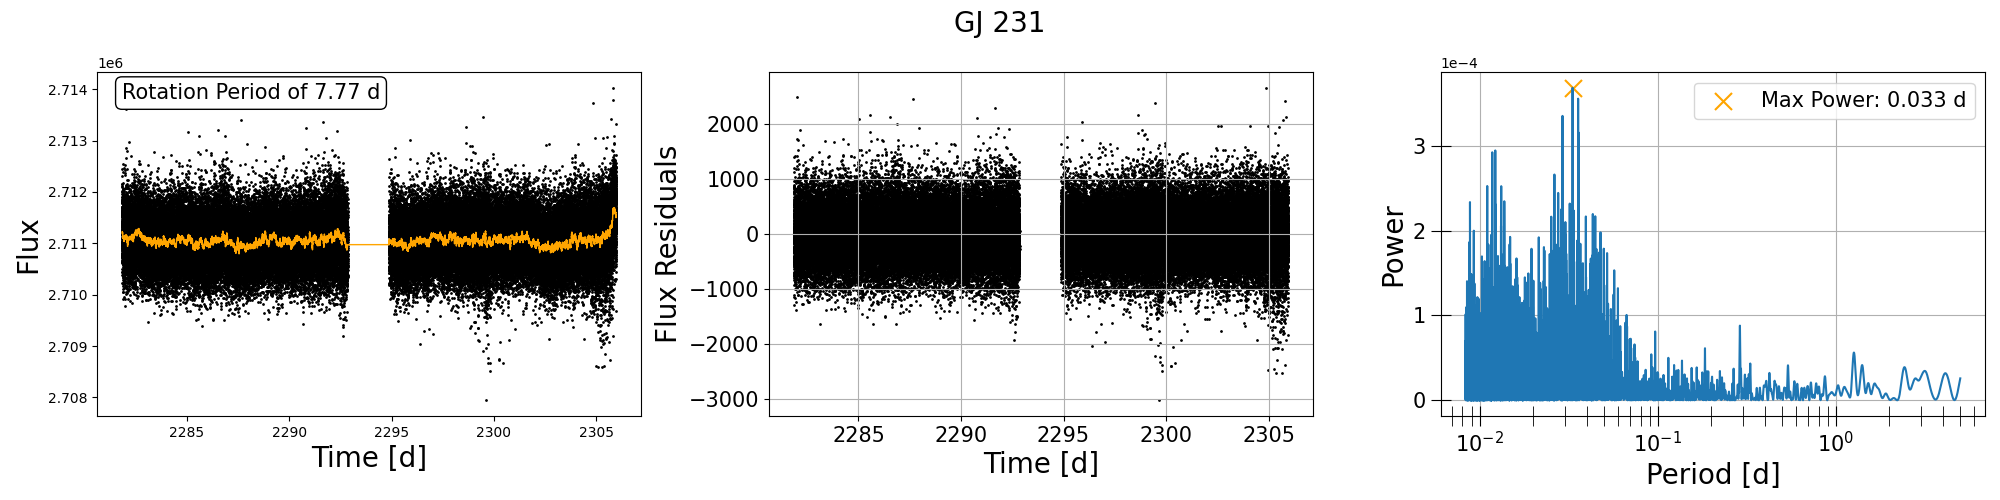

[-647.0, -303.0, 1006.5, 397.5, 615.75, -44.75, -549.0, 225.5, -719.75, -859.5]
[2088.4858646498055, 2088.4860961285376, 2088.48632760727, 2088.4865590860018, 2088.4867905647334, 2088.487022043466, 2088.487253522198, 2088.48748500093, 2088.4877164796917, 2088.4879479584242] [-647.0, -303.0, 1006.5, 397.5, 615.75, -44.75, -549.0, 225.5, -719.75, -859.5]


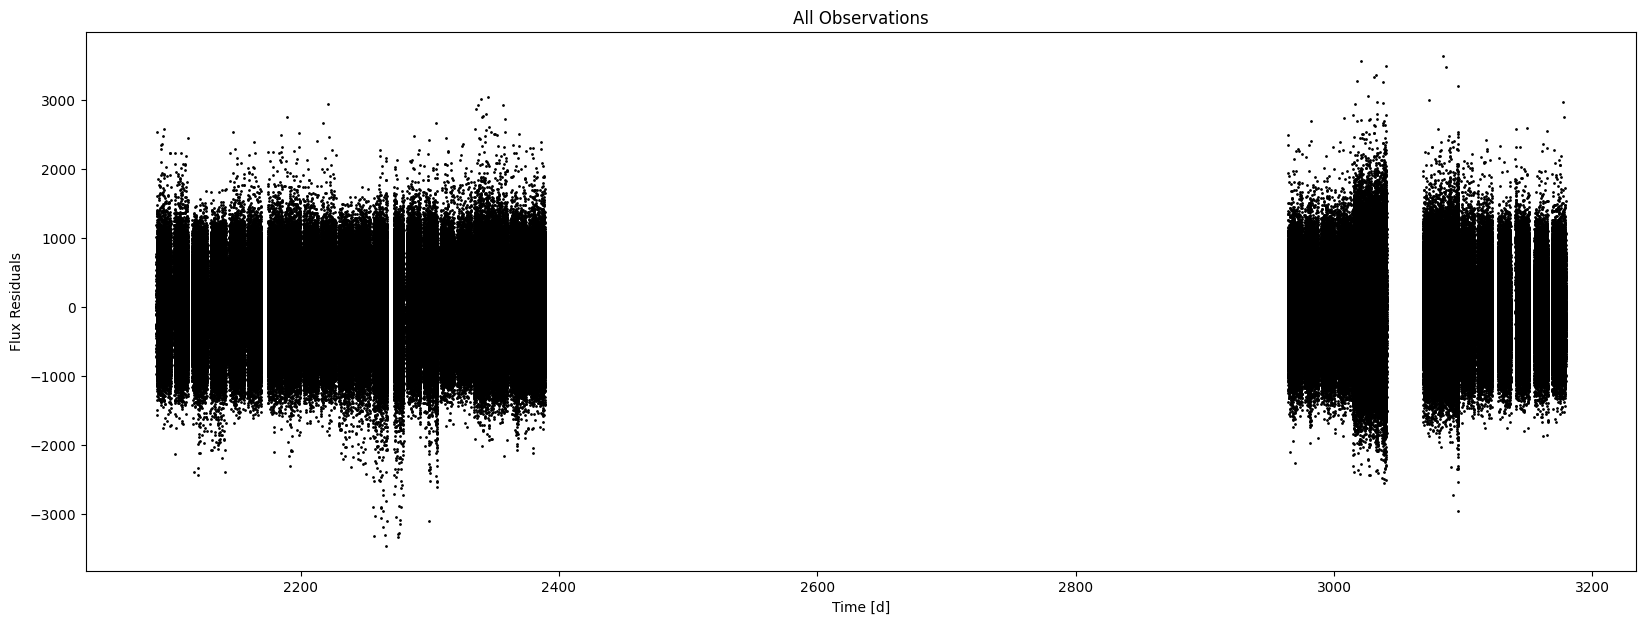

NameError: name 'bin_power' is not defined

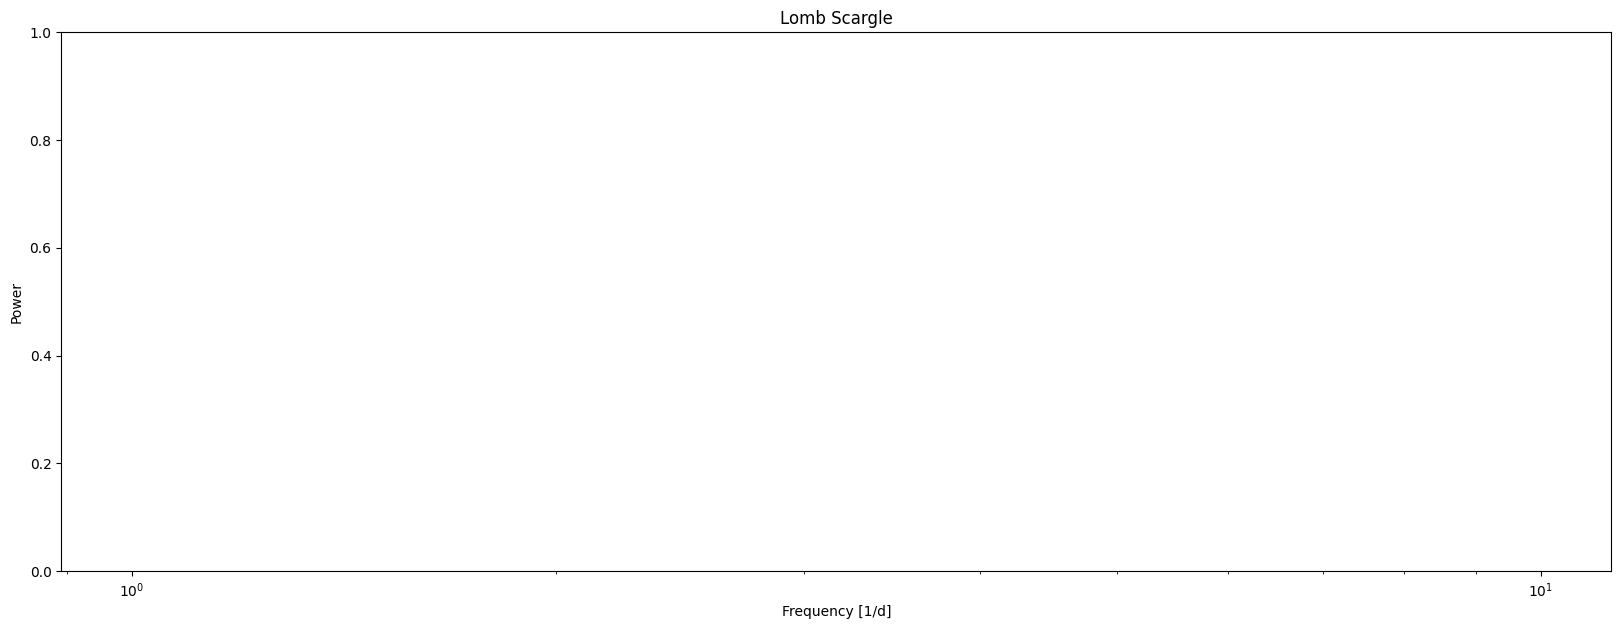

In [23]:
for star_number in multiple_observations_stars[30:31]:

    with open(f'/Users/caleb/research/Astro_98/multiple_observations/star_{star_number}_combined.pkl','rb') as f:
        data = pickle.load(f)

    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)

    spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}*.png"))]
    for i in spec_figures_paths[:1]:
        display(Image(filename=i)) 


    frequency = np.arange(0.004, 4000,0.008)
    # period = [1/i for i in frequency]
    cleaned_combined_times, cleaned_combined_residuals = data[0],data[1]
    # cleaned_combined_times, cleaned_combined_residuals = reject_outliers(np.array(data[0]), np.array(data[1]),10)
    print(cleaned_combined_residuals[0:10])

    power = LombScargle(cleaned_combined_times,cleaned_combined_residuals).power(frequency)


        
    print(cleaned_combined_times[0:10],cleaned_combined_residuals[0:10])
    plt.figure(figsize=(20,7))

    
    plt.scatter(cleaned_combined_times,cleaned_combined_residuals,s=1,color='black')
    # plt.xlim(2100,2200)
    plt.title("All Observations")
    plt.xlabel("Time [d]")
    plt.ylabel("Flux Residuals")
    plt.show()


    plt.figure(figsize=(20,7))

    plt.xscale('log')
    plt.title("Lomb Scargle")
    plt.xlabel("Frequency [1/d]")
    plt.ylabel("Power")


    binned_power, binned_frequency = bin_power(power,20,frequency)

    print(len(binned_power),len(binned_frequency))

    plt.plot(binned_frequency,binned_power,label='binned',color='orange')
    plt.plot(frequency,power,alpha=.5)

    plt.xscale('log')
    plt.xlabel("Frequency [1/d]")
    plt.ylabel("Power")
    plt.legend()
    plt.show()

In [24]:
def smooth_data(power,freq_bin_smooth,frequency):
    smooth_power = []
    smooth_freq = []
    for i in range(len(frequency)-freq_bin_smooth):
        smooth_freq.append(np.mean(frequency[i:i+freq_bin_smooth]))
        smooth_power.append(np.mean(power[i:i+freq_bin_smooth]))
    
    return smooth_freq, smooth_power

        
    

star number 134
['/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_8_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_15_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_12_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_7_of_19_weak_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_17_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_2_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_5_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_10_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_18_of_19_strong_rotation.png', '/Users/caleb/research/Astro_98/Figures/star_134_GJ 231_observation_19_of_19_strong_rotation.png',

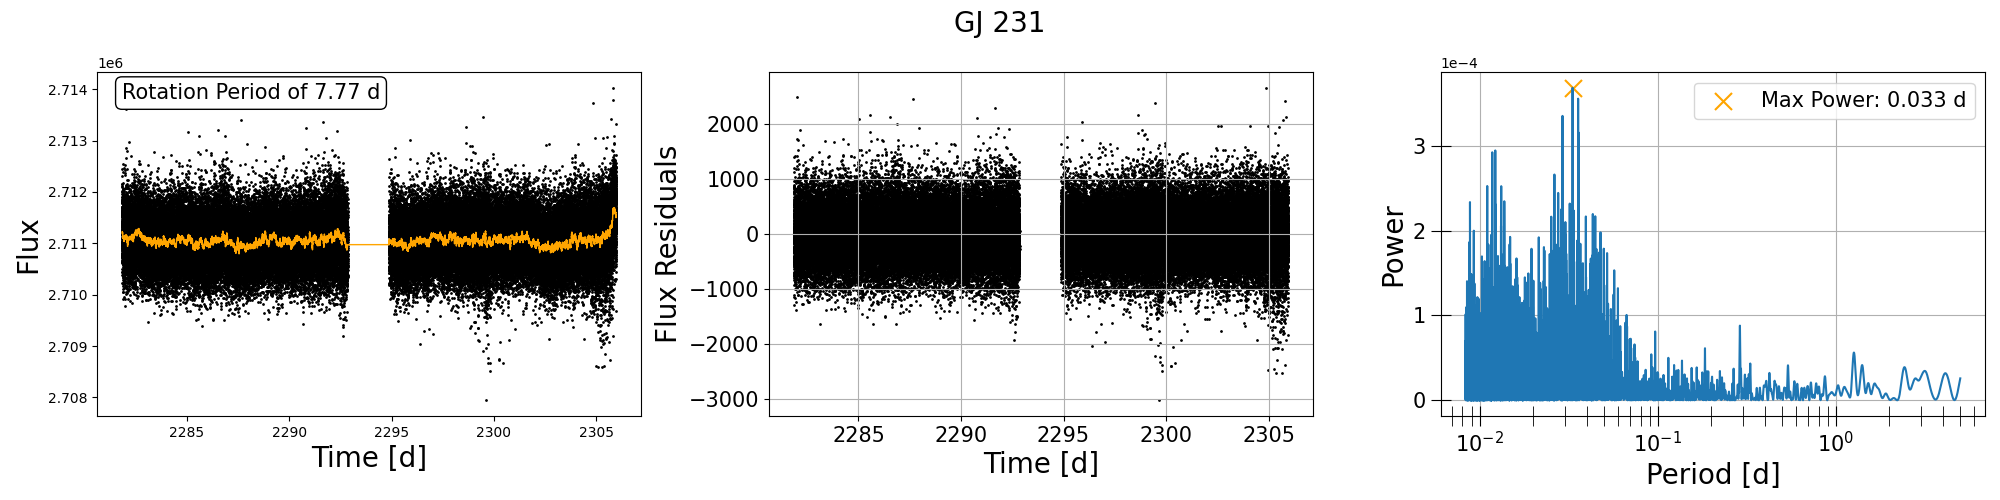

[-647.   -303.   1006.5   397.5   615.75  -44.75 -549.    225.5  -719.75
 -859.5 ]
[2088.48586465 2088.48609613 2088.48632761 2088.48655909 2088.48679056
 2088.48702204 2088.48725352 2088.487485   2088.48771648 2088.48794796] [-647.   -303.   1006.5   397.5   615.75  -44.75 -549.    225.5  -719.75
 -859.5 ]


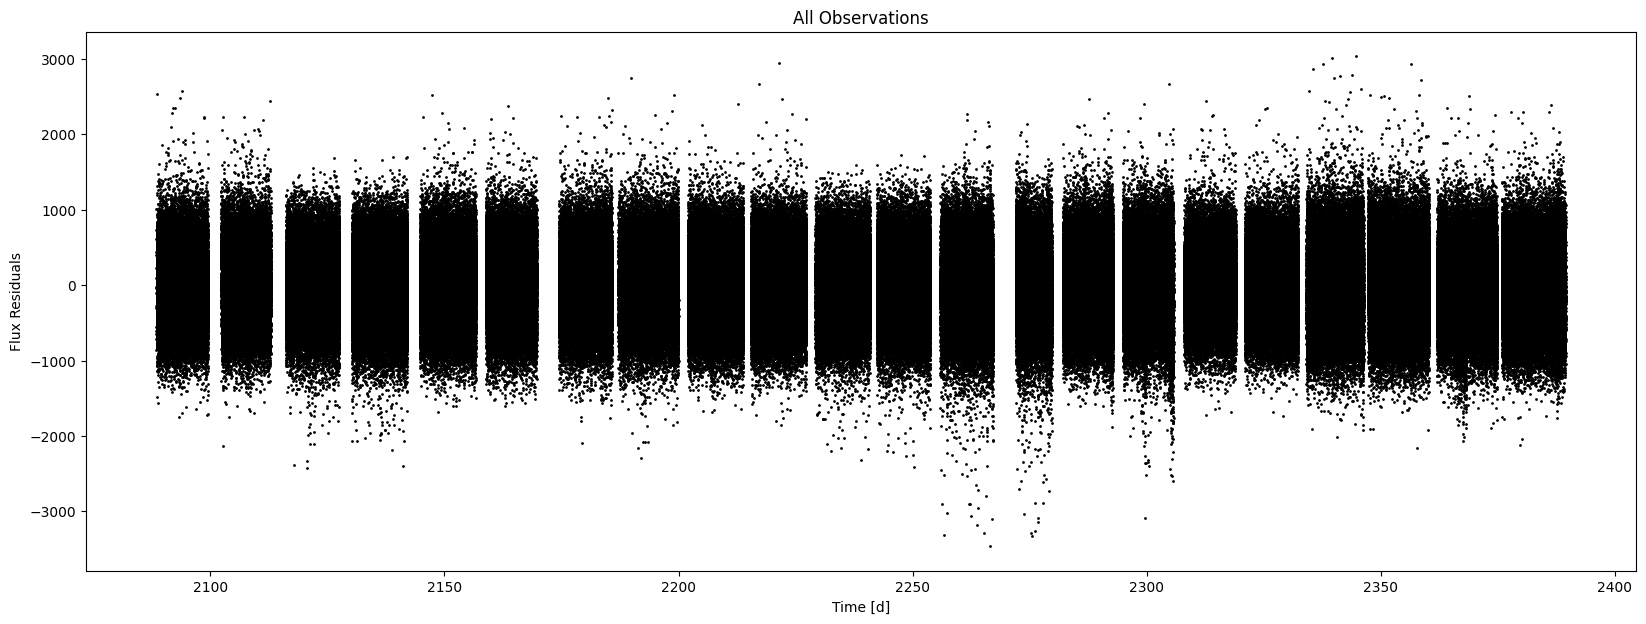

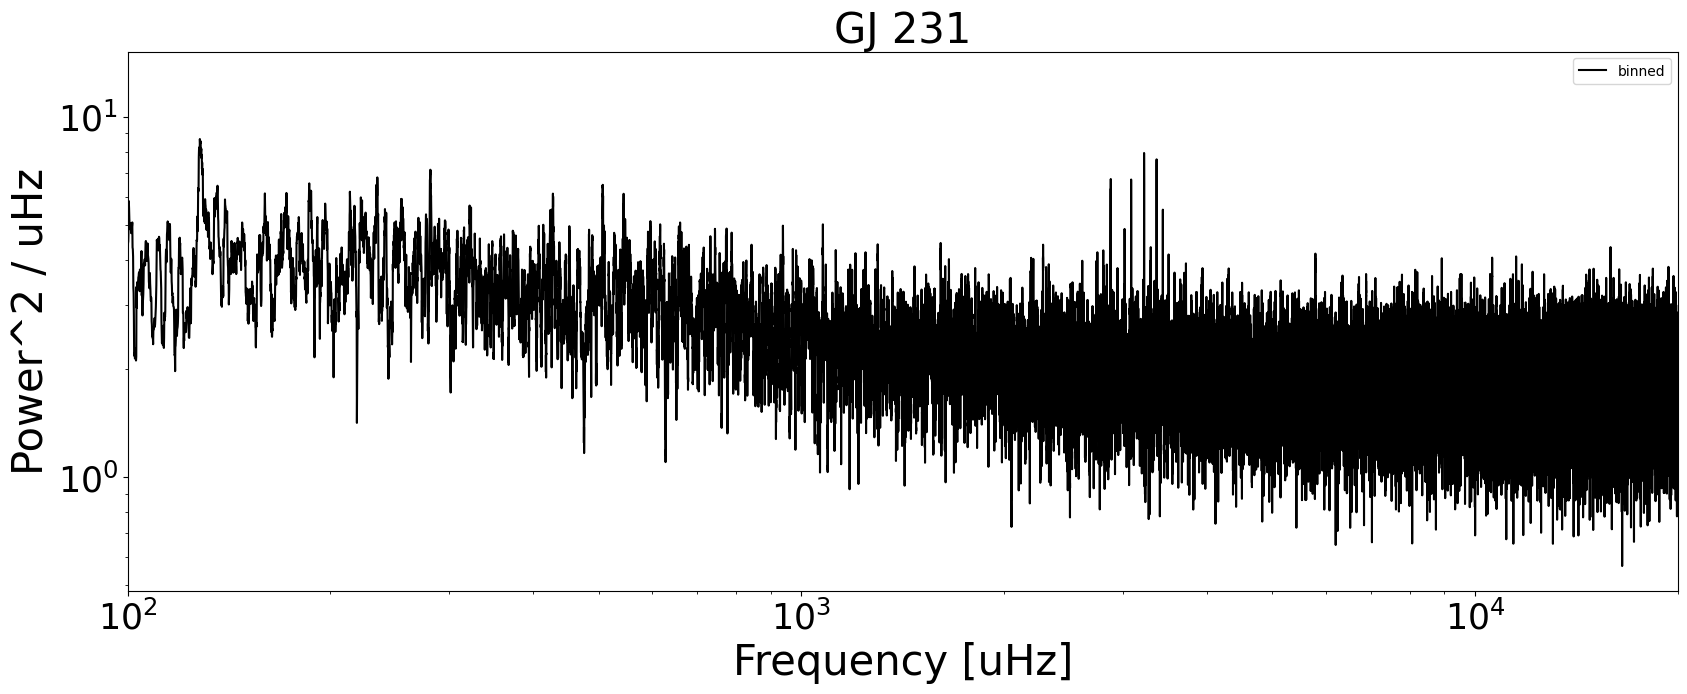

In [30]:
# look at interesting ones

for star_number in multiple_observations_stars[30:31]:

    print('star number',star_number)
    with open(f'/Users/caleb/research/Astro_98/multiple_observations/star_{star_number}_combined.pkl','rb') as f:
        data = pickle.load(f)

    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)

    spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}_*.png"))]
    print(spec_figures_paths)
    for i in spec_figures_paths[:1]:
        display(Image(filename=i)) 


    frequency = np.arange(0.004, 4000,0.008)
    # period = [1/i for i in frequency]
    cleaned_combined_times, cleaned_combined_residuals = np.array(data[0]),np.array(data[1])

    first_indices = np.where(cleaned_combined_times < 2450)

    cleaned_combined_times, cleaned_combined_residuals = cleaned_combined_times[first_indices], cleaned_combined_residuals[first_indices]

    # cleaned_combined_times, cleaned_combined_residuals = reject_outliers(np.array(data[0]), np.array(data[1]),10)
    print(cleaned_combined_residuals[0:10])

    power = LombScargle(cleaned_combined_times,cleaned_combined_residuals).power(frequency)

    # auto_freq, auto_power = LombScargle(cleaned_combined_times,cleaned_combined_residuals).autopower()
    # auto_frequency_microhertz = [(i*10**6)/(24*60*60) for i in auto_freq]


        
    print(cleaned_combined_times[0:10],cleaned_combined_residuals[0:10])
    plt.figure(figsize=(20,7))

    
    plt.scatter(cleaned_combined_times,cleaned_combined_residuals,s=1,color='black')
    # plt.xlim(2100,2200)
    plt.title("All Observations")
    plt.xlabel("Time [d]")
    plt.ylabel("Flux Residuals")
    plt.show()


    plt.figure(figsize=(20,7))


    freq_bin_smooth = 20

    # binned_power, binned_frequency = bin_power(power,freq_bin_smooth,frequency)
    power = 10**6*np.array(power)

    frequency_microhertz = [(i*10**6)/(24*60*60) for i in frequency]
    smooth_frequency_microhertz, smooth_power = smooth_data(power,freq_bin_smooth,frequency_microhertz)

    # binned_power, binned_frequency_microhertz = bin_power(power,freq_bin_smooth,frequency_microhertz)






    # binned_power_per_freq = []
    # for i in range(len(smooth_power)):
    #     binned_power_per_freq.append((smooth_power[i]*10**6)/smooth_frequency_microhertz[i])
    # plt.plot(frequency_microhertz, power,color='red',alpha=.3)
    plt.plot(smooth_frequency_microhertz, smooth_power,label='binned',color='black')
    # plt.plot(frequency,power,alpha=.5)

    plt.xscale('log')
    plt.yscale('log')

    # plt.title("Lomb Scargle")
    plt.xlabel("Frequency [uHz]",fontsize=30)
    plt.ylabel("Power^2 / uHz",fontsize=30)

    plt.title("GJ 231",fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(100,2*10**4)
    plt.legend()
    plt.show()




    # plt.plot(frequency_microhertz,power,label='binned',color='orange')
    # plt.plot(frequency,power,alpha=.5)
    # plt.xlabel("Frequency [uHz]")
    # plt.ylabel("Power^2 / uHz")

    # plt.xlim(10,2*10**4)
    # plt.xscale('log')

    # plt.show()

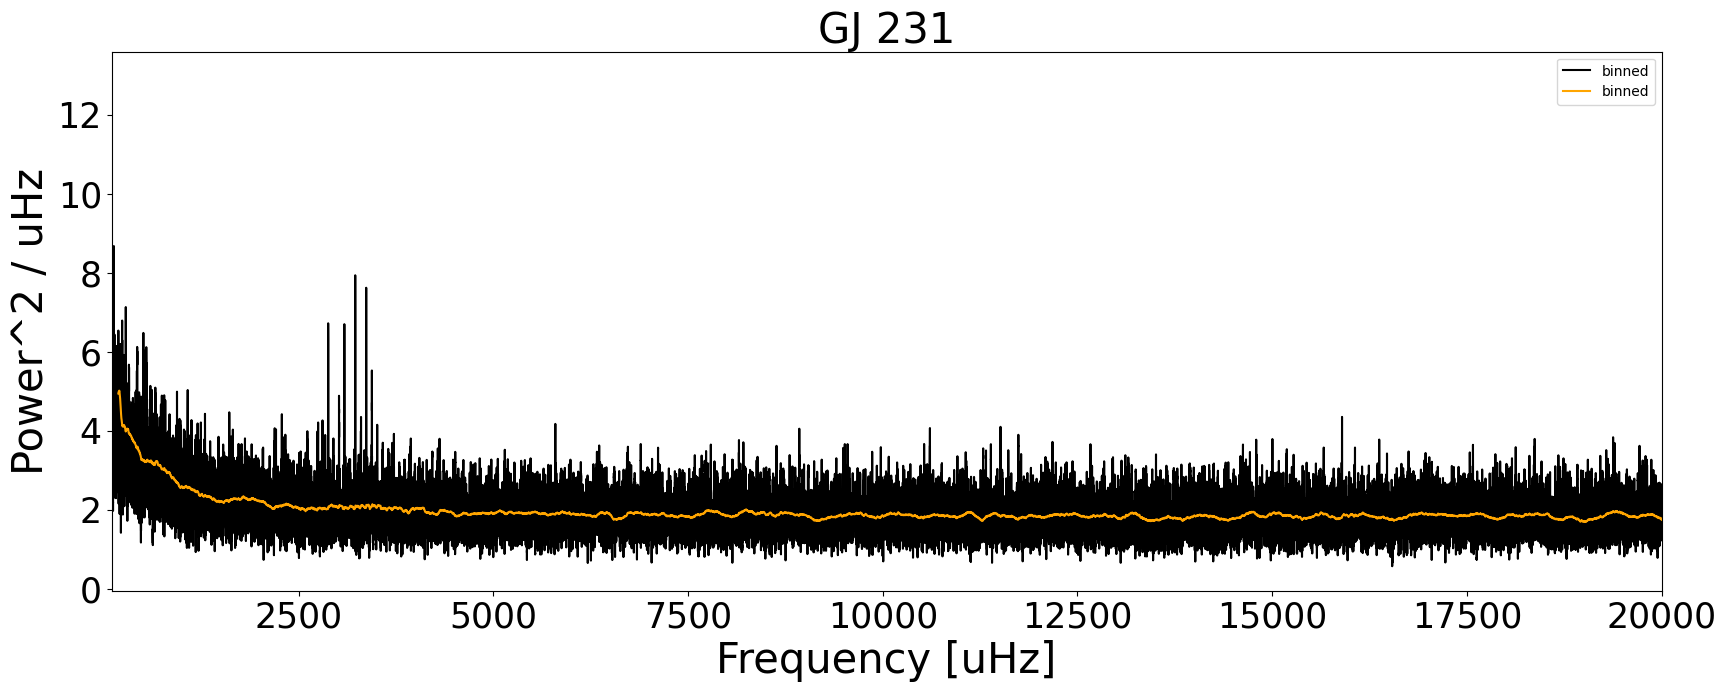

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


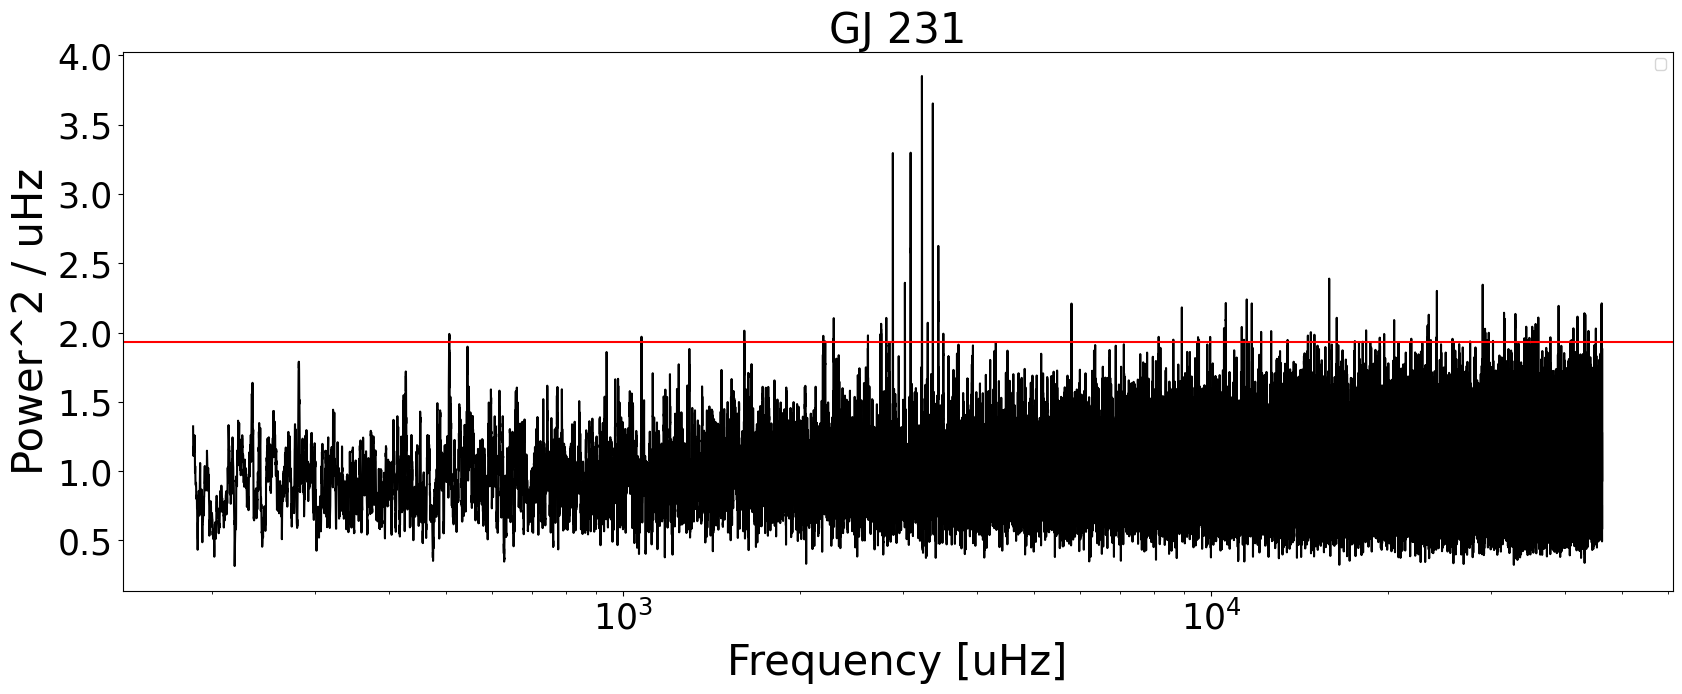

In [50]:




    plt.figure(figsize=(20,7))

    plt.plot(smooth_frequency_microhertz, smooth_power,label='binned',color='black')

    N = 2000
    running_average = np.convolve(smooth_power, np.ones(N)/N, mode='valid')
    plt.plot(smooth_frequency_microhertz[N-1:], running_average,label='binned',color='orange')
    # plt.plot(frequency,power,alpha=.5)

    # plt.xscale('log')
    # plt.yscale('log')

    # plt.title("Lomb Scargle")
    plt.xlabel("Frequency [uHz]",fontsize=30)
    plt.ylabel("Power^2 / uHz",fontsize=30)

    plt.title("GJ 231",fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(100,2*10**4)
    plt.legend()
    plt.show()


    plt.figure(figsize=(20,7))

    normalized = np.array(smooth_power)[N-1:]/np.array(running_average)
    plt.plot(smooth_frequency_microhertz[N-1:],normalized ,color='black')

    sig = 4*np.std(normalized)
    plt.axhline(y=1+sig,color='red')
    plt.xscale('log')
    # plt.yscale('log')

    # plt.title("Lomb Scargle")
    plt.xlabel("Frequency [uHz]",fontsize=30)
    plt.ylabel("Power^2 / uHz",fontsize=30)

    plt.title("GJ 231",fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    # plt.xlim(20,2*10**4)
    plt.legend()
    plt.show()


    


In [ ]:
# make sure it is same star
star_number = 149
spec_figures_paths = [str(i) for i in list(current_dir.glob(f"Figures/star_{star_number}*.png"))]
for i in spec_figures_paths:
    display(Image(filename=i)) 



In [ ]:
# plot only stars with multiple observations
for i in multiple_observations:
    num_obs = i[1]
    rows = int(np.ceil(num_obs / 4))
    fig, axs = plt.subplots(rows,4,figsize=(20,20))
    for obs in range(num_obs):
        try:
            with open(f'/Users/caleb/research/Astro_98/lomb_scargles/LS_star_{i[0]}_observation_{obs+1}_of_{num_obs}.pkl','rb') as f:
                power = pickle.load(f)
            name = names[i[0]]
            # long rotation period rotators
            max_power = np.max(power)
            strongest_period = period[np.argmax(power)]

            axs[int(np.floor(obs/4))][obs%4].plot(period,power/np.max(power))
            # axs[int(np.floor(obs/4))][obs%4].axvspan(.08,.1,alpha=.3,color='grey')
            axs[int(np.floor(obs/4))][obs%4].set_xlim(0.085,.095)
            axs[int(np.floor(obs/4))][obs%4].set_ylim(0,1.2)
        except:
            pass
    plt.suptitle(f"Star {i[0]}:{name}")
    plt.show()



## Exoplanet   

In [ ]:
# get rotation periods
all_periods = []
all_period_powers = []


for row in tqdm(range(0,10)):
    source_name = names[row]
    periods = []
    period_powers = []
    for num in range(len(eval(np.array(m_dwarf_sample["file paths"])[row]))):
        i = eval(np.array(m_dwarf_sample["file paths"])[row])[num]
        path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
        time, flux = plot_TESS(path,False,source_name)
        x,y = time,flux
        
        clean_time, clean_flux, median_flux = clean_data(x,y,source_name,False)

        frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
        power = LombScargle(clean_time, clean_flux).power(frequency)
        period = [1/i for i in frequency]


        if True:
            plt.plot(clean_time, clean_flux)
            plt.show()

            plt.plot(period, power, "k")
            # plt.yticks([])
            plt.xlabel("period [days]")
            plt.ylabel("Power")
            plt.xscale('log')
            plt.minorticks_on()
            plt.show()
        
        power =  power.tolist()
        max_power_index =power.index(np.max(power))
        print('period',period[max_power_index])
        periods.append(period[max_power_index])
        period_powers.append(np.max(power))

    all_periods.append(np.mean(periods))
    all_period_powers.append(np.mean(period_powers))




In [ ]:
m_dwarf_sample['Gmag']

In [ ]:
plt.plot(all_period_powers,all_periods)


In [ ]:
frequency = np.arange(0.01, 4000,.001)

In [ ]:
# lightkurve
row = 10
lcf = lk.search_lightcurve(names[row], mission='TESS',exptime=20).download()

lc = lcf.PDCSAP_FLUX.normalize().remove_nans()



x = np.array(lc.time.value)
y =np.array(lc.flux.value)
yerr = np.array(lc.flux_err)

mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

print(np.std(y))
print(yerr)

# mu = np.mean(y)
# y = (y / mu - 1) * 1e3
# yerr = yerr * 1e3 / mu

plt.scatter(x, y,s=.5)
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890")
plt.show()



import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=.1, max_period=10.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")

In [ ]:
yerr

In [ ]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    
    map_soln = xo.optimize(start=model.test_point)

## Comparing against Solar Oscillators ##

In [ ]:
import astroquery

In [ ]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
result = Vizier(columns=["*"], catalog="B/sb9/main")
print(result)
catalog_list = Vizier.find_catalogs('Solar-like oscillators catalogue')

print({k:v.description for k,v in catalog_list.items()})

catalogs = Vizier.get_catalogs(catalog_list.keys())
print(catalogs)
catalogue = catalogs[0]

In [ ]:
short_exposure_observations = catalogue[catalogue['sample'] == '20-sec']
TICs = short_exposure_observations["TIC"]

with open(f'/Users/caleb/research/Astro_98/tic_file_paths.pkl','rb') as f:
    tic_file_paths = pickle.load(f)


In [ ]:
tic_file_paths = []

for tic in tqdm(TICs[0:270]):
    observations = Observations.query_criteria(obs_collection='TESS', target_name=tic)
    short_exposure_obs = observations[observations['t_exptime']==20.0]
    if len(short_exposure_obs) > 0:
        product_list = Observations.get_product_list(short_exposure_obs)
        product_list_lcs = product_list[product_list['productSubGroupDescription']=='FAST-LC']
        file_paths_list = np.array(product_list_lcs['productFilename'])
        manifest = Observations.download_products(product_list_lcs)
        tic_file_paths.append(file_paths_list)
    else:
        print(f"no data for TIC {tic}")
        tic_file_paths.append('')


In [ ]:
with open(f'/Users/caleb/research/Astro_98/tic_file_paths.pkl','wb') as f:
    pickle.dump(tic_file_paths, f)


In [ ]:
TICs

In [ ]:
list(TICs).index(441462736)

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
# examine specific source
# frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
all_solar_powers = np.array([0.0]*len(frequency))


for row in range(174,180):
    source_name = TICs[row]
    print(source_name)
    file_paths = tic_file_paths
    row_paths = file_paths[row]
    print(len(row_paths))
    for num in range(len(row_paths)):
        try:
            i = row_paths[num]
            path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
            time, flux = plot_TESS(path,False,source_name)

            window_size= 2000
            clean_time, clean_flux, median_flux,rotation_period, max_power = clean_data(time, flux,source_name,False,window_size)
            
            fig, axs = plt.subplots(1,3,figsize=(20,5))

            frequency = np.arange(0.004, 2000,0.008)
            power = LombScargle(clean_time, clean_flux).power(frequency)
            period = [1/i for i in frequency]

            # all_solar_powers += power

            axs[0].scatter(time, flux,color='black',s=1)
            rotation_strength = 'strong'
            if max_power > .15:
                rotation_label= f"Rotation Period of {np.round(rotation_period,2)} d"
            if max_power < .15:
                rotation_label= "Weak Rotation Period"
                rotation_strength = 'weak'

            with open(f'/Users/caleb/research/Astro_98/diff_window_filter_solar/LS_solar_star_{row}_TIC_{source_name}_observation_{num+1}_of_{len(row_paths)}.pkl','wb') as f:
                pickle.dump(power, f)

            props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
            # place a text box in upper left in axes coords
            axs[0].text(np.min(time),np.mean(flux)+.9*(np.max(flux)-np.mean(flux)),rotation_label, fontsize=15, horizontalalignment='left',verticalalignment='bottom', bbox=props)

            axs[0].plot(time[int(window_size/2):-int(window_size/2)], np.array(median_flux),color='orange',linewidth=1)
            axs[0].set_ylabel("Flux",fontsize=20)
            axs[0].set_xlabel("Time [d]",fontsize=20)


            axs[1].scatter(clean_time, clean_flux,color='black',s=1)
            axs[1].tick_params(labelsize=15)
            axs[1].grid()
            axs[1].set_ylabel("Flux Residuals",fontsize=20)
            axs[1].set_xlabel("Time [d]",fontsize=20)
            plt.suptitle(source_name,fontsize=20)

            # power = power/np.max(power)

            axs[2].plot(frequency,power)

            peaks,_ = find_peaks(power,height=.5, distance=1000)

            
            # axs[2].scatter(period[list(power).index(max(power))],power[list(power).index(max(power))],color='orange',s=150,marker='x',label=f'Max Power: {np.round(period[list(power).index(max(power))],3)} d')
            
            axs[2].scatter(frequency[peaks],power[peaks],color='orange',s=150,marker='x')

            # n = [frequency[peak] for peak in peaks]
            # for i, txt in enumerate(n):
            #     axs[2].annotate(txt, (frequency[peaks][i], power[peaks][i]))


            # axs[1].set_xscale('log')
            # axs[1].set_yscale('log')

            oscillation_freq = short_exposure_observations[short_exposure_observations["TIC"] == source_name]['numax'][0]
            oscillation_freq_error = short_exposure_observations[short_exposure_observations["TIC"] == source_name]['e_numax'][0]
            print('osc freq', oscillation_freq)
            oscillation_period = 1/((oscillation_freq/1000000)*(1/((1/24)*(1/60)*(1/60))))
            oscillation_period_plus = 1/(((oscillation_freq+2*oscillation_freq_error)/1000000)*(1/((1/24)*(1/60)*(1/60))))
            oscillation_period_minus = 1/(((oscillation_freq-2*oscillation_freq_error)/1000000)*(1/((1/24)*(1/60)*(1/60))))

            

            axs[2].tick_params(axis='both', which='both',direction='inout',length=15,labelsize=15)
            axs[2].grid()


            axs[2].axvspan(oscillation_period_plus,oscillation_period_minus,color='grey',alpha=.2,label='Catalogue Oscillation Period')

            axs[2].set_ylabel("Power",fontsize=20)
            axs[2].set_xlabel("Frequency [1/d]",fontsize=20)
            axs[2].set_xscale("log")
            axs[2].ticklabel_format(axis='y', style='sci',scilimits=(.01,100))
            plt.subplots_adjust(wspace=.3)
            plt.legend(fontsize=15)
            plt.tight_layout()
            # plt.savefig(f'/Users/caleb/research/Astro_98/Figures_solar/solar_star_{row}_TIC_{source_name}_observation_{num+1}_of_{len(row_paths)}_{rotation_strength}_rotation.png')
            plt.show()

            binned_power, binned_frequency = bin_power(power,50,frequency)

            print(len(binned_power),len(binned_frequency))


            frequency_microhertz = [(i*10**6)/(24*60*60) for i in frequency]
            smooth_frequency_microhertz, smooth_power = smooth_data(power,20,frequency_microhertz)

            binned_power_per_freq = []
            for i in range(len(smooth_power)):
                binned_power_per_freq.append((smooth_power[i]*10**6)**2/smooth_frequency_microhertz[i])


            plt.plot(smooth_frequency_microhertz,binned_power_per_freq)

            gaussian_smoothed = gaussian_filter(power,20)
            binned_power_per_freq = []
            for i in range(len(smooth_power)):
                binned_power_per_freq.append((smooth_power[i]*10**6)**2/smooth_frequency_microhertz[i])

            plt.plot(smooth_frequency_microhertz,binned_power_per_freq,color='red',alpha=.5)

            plt.yscale('log')
            plt.xscale('log')
            plt.xlim(100,20000)
            plt.show()

            
        except Exception:
            print('path error',path)
            print(traceback.format_exc())    


In [ ]:
# examine specific source
# frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
all_solar_powers = np.array([0.0]*len(power))


for row in [174]:
    source_name = TICs[row]
    print(source_name)
    file_paths = tic_file_paths
    row_paths = file_paths[row]
    print(len(row_paths))
    for num in range(len(row_paths)):
        try:
            i = row_paths[num]
            path = '/Users/caleb/research/Astro_98/mastDownload/TESS/'+i[:-8]+"/"+i
            time, flux = plot_TESS(path,False,source_name)

            window_size= 180
            clean_time, clean_flux, median_flux,rotation_period, max_power = clean_data(time, flux,source_name,False,window_size)
            
            fig, axs = plt.subplots(1,3,figsize=(20,5))

            # frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
            # power = LombScargle(clean_time, clean_flux).power(frequency)

            frequency, power = LombScargle(clean_time, clean_flux).autopower()
            
            period = [1/i for i in frequency]

            # all_solar_powers += power

            axs[0].scatter(time, flux,color='black',s=1)
            rotation_strength = 'strong'
            if max_power > .15:
                rotation_label= f"Rotation Period of {np.round(rotation_period,2)} d"
            if max_power < .15:
                rotation_label= "Weak Rotation Period"
                rotation_strength = 'weak'

            with open(f'/Users/caleb/research/Astro_98/lomb_scargles_solar/LS_solar_star_{row}_TIC_{source_name}_observation_{num+1}_of_{len(row_paths)}.pkl','wb') as f:
                pickle.dump(power, f)

            props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
            # place a text box in upper left in axes coords
            axs[0].text(np.min(time),np.mean(flux)+.9*(np.max(flux)-np.mean(flux)),rotation_label, fontsize=15, horizontalalignment='left',verticalalignment='bottom', bbox=props)

            axs[0].plot(time[int(window_size/2):-int(window_size/2)], np.array(median_flux),color='orange',linewidth=1)
            axs[0].set_ylabel("Flux",fontsize=20)
            axs[0].set_xlabel("Time [d]",fontsize=20)


            axs[1].scatter(clean_time, clean_flux,color='black',s=1)
            axs[1].tick_params(labelsize=15)
            axs[1].grid()
            axs[1].set_ylabel("Flux Residuals",fontsize=20)
            axs[1].set_xlabel("Time [d]",fontsize=20)
            plt.suptitle(source_name,fontsize=20)


            axs[2].plot(period,power)
            axs[2].scatter(period[list(power).index(max(power))],power[list(power).index(max(power))],color='orange',s=150,marker='x',label=f'Max Power: {np.round(period[list(power).index(max(power))],3)} d')

            # axs[1].set_xscale('log')
            # axs[1].set_yscale('log')

            oscillation_freq = short_exposure_observations[short_exposure_observations["TIC"] == source_name]['numax'][0]
            oscillation_freq_error = short_exposure_observations[short_exposure_observations["TIC"] == source_name]['e_numax'][0]
            print('osc freq',oscillation_freq)
            oscillation_period = 1/((oscillation_freq/1000000)*(1/((1/24)*(1/60)*(1/60))))
            oscillation_period_plus = 1/(((oscillation_freq+2*oscillation_freq_error)/1000000)*(1/((1/24)*(1/60)*(1/60))))
            oscillation_period_minus = 1/(((oscillation_freq-2*oscillation_freq_error)/1000000)*(1/((1/24)*(1/60)*(1/60))))

            

            axs[2].tick_params(axis='both', which='both',direction='inout',length=15,labelsize=15)
            axs[2].grid()


            axs[2].axvspan(oscillation_period_plus,oscillation_period_minus,color='grey',alpha=.2,label='Catalogue Oscillation Period')

            axs[2].set_ylabel("Power",fontsize=20)
            axs[2].set_xlabel("Period [d]",fontsize=20)
            axs[2].set_xscale("log")
            axs[2].ticklabel_format(axis='y', style='sci',scilimits=(.01,100))
            # plt.xlim(.02,.04)
            plt.subplots_adjust(wspace=.3)
            plt.legend(fontsize=15)
            plt.tight_layout()
            plt.savefig(f'/Users/caleb/research/Astro_98/Figures_solar/solar_star_{row}_TIC_{source_name}_observation_{num+1}_of_{len(row_paths)}_{rotation_strength}_rotation.png')
            plt.show()

            
        except Exception:
            print('path error',path)
            print(traceback.format_exc())    


In [ ]:
bin_size = 1000

binned_data = []
binned_frequency = []

median_size = 10000
running_median = []

for i in range(len(power)):
    print(i)
    start = i*bin_size
    end = (i+1)*bin_size
    if end < len(power):
        binned_data.append(np.mean(power[start:end]))
        binned_frequency.append(np.mean(frequency[start:end]))
    else:
        break

for i in range(len(power)-median_size):
    running_median.append(np.median(power[i:i+median_size]))


In [ ]:
normalized_binned_data = binned_data
normalized_median = running_median

binned_period =[1/i for i in binned_frequency]

plt.plot(binned_period,normalized_binned_data)


plt.plot([1/i for i in frequency][5000:-5000],running_median)

plt.xscale("log")
plt.yscale('log')
plt.xlim(0,1)

In [ ]:
normalized_power = power/power[-1]

bin_size = 10

binned_data = []

for i in range(len(power)):
    try:
        binned_data.append(np.sum(power[i*10:(i+1)*10]))
    except:
        break

plt.plot([1/i for i in frequency],normalized_power)
plt.xscale("log")
plt.xlim(0,1)

In [ ]:
short_exposure_observations = pd.read_csv('/Users/caleb/research/Astro_98/short_exposure_observations.csv',delimiter=',',index_col=0)

In [ ]:
short_exposure_observations

In [ ]:
list(TICs).index(441462736)

In [ ]:
float(short_exposure_observations[short_exposure_observations["TIC"]==15132927]["numax"].iloc[0])

In [ ]:
# add up solar oscillators
# frequency = np.arange(.2,(24/.2),((20/(60*60))/24))
frequency = np.arange(0.004, 2000,0.008)

cwd = os.getcwd()
current_dir = pathlib.Path(cwd)

solar_scargles = [str(i) for i in list(current_dir.glob(f"diff_window_filter_solar/LS_solar_star*.pkl"))]


num = 0
all_solar_powers = np.array([0.0]*len(frequency))
for scargle in solar_scargles:
    print(scargle)
    with open(scargle,'rb') as f:
        num +=1 
        spec_power = pickle.load(f)
        try: 
            all_solar_powers += np.array(spec_power)/np.max(spec_power)
        except:
            print('pass')


print(num)

In [ ]:
normalized_all_solar_power = all_solar_powers/all_solar_powers[-1]
all_running_median = []
median_bin_size = 6000
for i in range(len(normalized_all_solar_power[:-median_bin_size])):
    all_running_median.append(np.median(normalized_all_solar_power[i:i+median_bin_size]))

In [ ]:

plt.plot(frequency,all_solar_powers)
# plt.plot(period[int(median_bin_size/2):-int(median_bin_size/2)],all_running_median)
# plt.axvline(x=.03)
# plt.axvline(x=.012)
plt.xscale('log')
# plt.xlim(0,1)
plt.title("240 bin size filter")
plt.xlabel("Freq [uHz]")
plt.ylabel("Power")




In [ ]:

plt.plot(frequency,all_solar_powers)
# plt.plot(period[int(median_bin_size/2):-int(median_bin_size/2)],all_running_median)
# plt.axvline(x=.03)
# plt.axvline(x=.012)
plt.xscale('log')
# plt.xlim(0,1)
plt.title("100 bin size filter")
plt.xlabel("Freq [uHz]")
plt.ylabel("Power")


